# Import of libraries

In [2]:
# Important libraries imported
import numpy as np
from matplotlib import pyplot
from struct import*
import pandas as pd
import math
import os
from numpy import nan
from matplotlib import pyplot as plt

# Reading file, shaping 3D matrix and plot of CT/PET.
- The code below unpacks the FDG-PET images and CT and converts them to arrays in 3D.
- As explained in section methods, images can be plotted diagnally, horizontally or vertically.

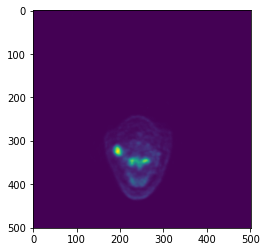

In [4]:

# Function to read information text file.
# Information text files contain additional information about the image file.
# This function reads the information text file and returns an array containing the information.
def read_info_txt(file):
    with open(file, mode='r') as file: 
        fileContent = file.read()
        SplitFile = fileContent.split()
        array_info_txt = []
        for i in range(len(SplitFile)):
            array_info_txt.append(float(SplitFile[i]))
    return array_info_txt

# Function to read image data and create a 3D matrix
# This function reads a CT or PET image file and returns a 3D matrix representing the image.
def read_CT_PET(PatientNumber, Image='CT'):
    # Path to patient image files.
    Part_readfile = '/volumes/LaCie/Sagal/HN_ANON_09102017/Patient_Folders/'
    # String used to concatenate file paths.
    strek ='/'
    
    # Determine image type based on input argument.
    if Image == 'CT':
        Imaging = 'CT'
    else:
        Imaging = 'PT'
    
    # Construct file path.
    file = Part_readfile + PatientNumber + strek + Imaging
    
    # Read binary data from file.
    with open(file, mode='rb') as file: 
        fileContent = file.read()
    
    # Convert binary data to array of unsigned short integers (16 bits).
    Unpack = unpack("H" * ((len(fileContent)//2)), fileContent) 
    
    # Read information text file.
    # Information text files contain the dimensions of the image and the maximum pixel value.
    remaining = '_info.txt'
    InfoTextFile = Part_readfile + PatientNumber + strek + PatientNumber + remaining
    ydim, xdim, zdim, SUVMax, CTMax = read_info_txt(InfoTextFile)
    Matrix3D = []
    
    # Create 3D matrix from image data.
    array_data = np.array(Unpack)
    for i in range(int(zdim)):
        # Extract 2D image data from array.
        Image_array = (array_data[i * int(xdim) * int(ydim):(i + 1) * int(xdim) * int(ydim)])
        # Reshape 2D image data into a 2D array.
        ReshapeImage = np.reshape(Image_array, [int(xdim), int(ydim)])
        # Convert pixel values to Hounsfield Units (CT) or Standardized Uptake Values (PET).
        if Image == 'CT':
            CT_array = ReshapeImage * CTMax / (2 ** 16 - 1)
            Matrix3D.append(CT_array)
        else:
            PET_array = ReshapeImage * SUVMax / (2 ** 16 - 1)
            Matrix3D.append(PET_array)
    # Convert list of 2D arrays to 3D array.
    Matrix3D_array = np.array(Matrix3D)
    # Remove any unnecessary dimensions.
    Matrix3D_new = np.squeeze(Matrix3D_array)
    # Return 3D matrix.
    return Matrix3D_new

# Patient number and type of imaging inserted.
# PET image of patient number 8 is inserted. 
Image_Matrix = read_CT_PET('P008','PET')



def plot(Layer):
    Layer_Image = Image_Matrix[Layer]
    plot = pyplot.imshow(Layer_Image)# Display 2D image
    return plot 
plot(167)

# Read of raw_text, and extraction of z, y and x coordinate values.
- Raw_text contains information on SUV,HU-units and coordinates of the patients stores as indexes.
- How this information is extracted is described in section 3.3 Data preperation

In [5]:
# This function reads where GTV starts from. 
def Search_GTV(file):
    enc = 'iso-8859-15'
    f = open(file,encoding=enc)
    lines =f.readlines()
    LineNumber = []
    Header = []
    for line_number, line in enumerate(lines):
        if 'GTV' in line:
            LineNumber.append(line_number)
            Header.append(line)
    return LineNumber,Header

# This is just a function that reads the file.
def readline(file,k):
    enc = 'iso-8859-15'
    with open(file,encoding=enc, mode='r') as file:
        for i in range(int(k)):
            fileContent = file.readline()
        filecontent = file.read()
        return filecontent

# This creates an array
def array_creator(SplitFile):
    array_info_txt = []
    for i in range(len(SplitFile)):
        try:
            array_info_txt.append(float(SplitFile[i]))
        except ValueError:
            break
    return array_info_txt

# This gets out whole array

def array(file):
    Start_point,GTV_Names = Search_GTV(file)
    filecontent = readline(file,Start_point[0]+1)
    SplitFile = filecontent.split()
    count = SplitFile.count('GTV')
    Array_Whole = []
    Position = []
    i = 0
    while i < count+1:
        if len(SplitFile) == 0:
            break
        else:
            Array = array_creator(SplitFile)
            position = len(Array)/3 + 2
            Position.append(position)
            Array_Whole.append(Array)
            filecontent = readline(file,Start_point[0]+1+np.sum(Position))
            SplitFile = filecontent.split()
        i += 1
    return Array_Whole



def Func_Concat_Header_Array_Index_PT_CT(file,Index_type='Index'):
    LineNumber,Header = Search_GTV(file)
    Array_Whole = array(file)
    Array_Index_Whole = []
    if Index_type == 'Index':
        for i in Array_Whole:
            Array = i[0::3]
            Array_Index_Whole.append(Array)
    elif Index_type == 'PT':
        for i in Array_Whole:
            Array = i[1::3]
            Array_Index_Whole.append(Array)
    elif Index_type == 'CT':
        for i in Array_Whole:
            Array = i[2::3]
            Array_Index_Whole.append(Array)
    Concat_Header_Array = []
    for j, i in enumerate(Array_Index_Whole):
        Concat_Header_Array.append([Header[j],i])
    return Concat_Header_Array

# Function to convert Index Values to Pixel Numbers
# Try to find voxel on which doctor has drawn lines.

def convert_index_to_pixel(PatientNumber):
    z_index = []
    y_index = []
    x_index = []
    Part_readfile = '/volumes/LaCie/Sagal/HN_ANON_09102017/Patient_Folders/'
    strek ='/'
    file_text = '_info.txt'
    file_raw = '_raw_data.txt'
    InfoTextFile = Part_readfile + PatientNumber + strek + PatientNumber + file_text
    RawTextFile  = Part_readfile + PatientNumber + strek + PatientNumber + file_raw
    Index_data = Func_Concat_Header_Array_Index_PT_CT(RawTextFile,Index_type='Index')
    names = []
    for i in Index_data:
        for index in i:
            if 'GTV' in index:
                names.append(index)
                continue
            else:
                ydim,xdim,zdim,SUVMax,CTMax = read_info_txt(InfoTextFile)
                z = np.floor(np.array(index)/(xdim*ydim))
                y = np.floor((np.array(index)-z*xdim*ydim)/(ydim))
                x = np.array(index) - z*xdim*ydim-y*ydim
            z_index.append(z)
            y_index.append(y)
            x_index.append(x)
    return z_index,y_index,x_index,names,SUVMax
# Husk du har lagt til SUVMax. Kan hende du opplever utfordringer når du kjører gammel kode.

# Create a function that reads out the correct tumor. We are intrested in GTV PET.
- This codes helps read the correct tumor. There are other tumor delineation as well available in file.
- We are intrested in primary tumor. This is read from a file.

In [6]:

# Code reading in GTV names together with Patient Number.
df = pd.read_excel('GTVNames.xlsx',skiprows=14) # Cod reading in GTV names that shall be used. 
GTV = df.iloc[:,2] # Chosing correct column
GTVNames = GTV.to_numpy() # Convert to Numpy array

#Function reading out correct Tumor.
def CorrectTumorChoice(PatientNumber):

    #array_names = ['GTV prim tum CT (70 Gy) ','GTV/CT prim tum ( 70 Gy)','GTV prim tum CT (70 Gy) ','GTV CT (70 Gy)','GTVtumor/pb ','GTVtumor(70 gy)/henma ','GTVtumor/AN ','GTV/JFE (70 Gy) ','GTVtumor(70gy)/henma','GTV_PET_TUMOR ','GTV_Tumor_PET ','GTVtumor','GTV tumor/brt ','GTVvetonsille/henma ','GTV tumor 70 Gy- uxjolp ','GTV tumor (70 Gy) - uxjolp','GTV_PET_TUMOR (70 Gy) ','GTV prim tum PET/CT (70 Gy) ','GTV_tumor_PET_TVB ','GTV_TUMOR_PET_TVB ','GTV_PET_TUMOR_TVB ','GTV_PET_tumor_TVB ','GTV_PET_TVB ','GTV_PET_tvb ','GTV PET (70 Gy) ','GTV PET JFE (70 Gy) ','GTV primtum PET (70 Gy) ','GTV tumor PET CT','GTV_PET_tumor ','GTV_tumor_PET_tvb ','GTV_tumor_PET_AL','GTV_LNSIN_PET_TVB ','GTV_tumor_PET (70 Gy) ','GTV_tumor_PET ','GTV prim tum PET/CT,GTV prim tum PET/CT (70 Gy)','GTV PET prim tum (70 Gy)','GTV prim tum PET (70 Gy)','GTV prim tum PET','GTV prim tum PET ()70 Gy)', 'GTV_PET_TUMOR (70 Gy)','GTV_PRIMTUM_PET (70 Gy)','GTV CT','GTV PET (70 Gy)' ,'GTV prim tum (70 Gy)','GTV prim tum PET','GTV prim tum MR','GTV prim tum CT (70 Gy)' ,'GTV prim tum CT (70 Gy)','GTV tumor 70GY/MN','GTV_TUMOR_PET hs_TVB','GTV_tumor_PET_tvb','GTV primtum PET JFE (70 Gy)','GTV_TUMOR_PET_TVB','GTV_PET_tumor_TVB','GTV_TUMOR?_PET_TVB','GTV_TUMOR_PET_TVB 70 Gy' ,'GTV_PET_tumor_TVB','GTV_PET_TUMOR_TVB','GTV_tumor_PET_TVB' ,'GTV_tumor_PET_TVB (70 Gy)','GTV-PET l.gl ve 1/brt' ,'GTV-PET lgl ve2/brt','GTV tonsille (70 Gy)/pbk','GTV prim tum (68 Gy)','GTV_TUMOR_PET ','GTV prim tum','GTV_LNdex_PET','GTV_origo?_PET']
    array_names = GTVNames
    PatientWithTumor=[]
    if PatientNumber == 'P118':
        pass
    else:
        Z,Y,X,names,SUVMax = convert_index_to_pixel(PatientNumber)
    KO = []
    Names = []
    results = [] # Will contain array name, and Array number later.
    for i in names:
        string = i.strip('\n')
        Names.append(string)
    for i in range(len(Names)):
        Namy = Names[i]
        for k in array_names:
            if Namy == k:
                KO.append(Namy)
                KO.append(i)
                PatientWithTumor.append(PatientNumber)
                return Namy,i,PatientWithTumor
    empty_array = np.array(KO) # Brude denne snipp biten til å legge igjen de jeg ikke finner Tumor for. 
    if empty_array.size == 0:
        pass
        return print('No Tumor Found'),print(Names),print(PatientNumber)



# Function that creates patient list
def PatientList(Number):
    Patient_List = []
    PossibleAvailable = []
    for i in range(1,Number+1):
        PossibleAvailable.append(i)
        Standard = 'P'
        OneZero = '0'
        TwoZer0 = '00'
        digits = int(math.log10(i))+1 # Use this to code number of digits of 'i'
        if digits == 1:
            PatientNum = Standard + TwoZer0 + str(i)
        elif digits == 2:
            PatientNum = Standard + OneZero + str(i)
        else:
            PatientNum = Standard + str(i)
        Patient_List.append(PatientNum)
    return Patient_List

# In number you incert number of patients you want to check out.
# You get information on which tumours available, and those that are not. 
def Check_Funtion(Number):
    NumberAvailable = [] # Number avaialble tumors.
    AbsentFilesNumber = [] # Number absent files. 
    for i in (PatientList(Number)):
        try:
            GTVName,GTVPositionNumber,PatientWithTumor = CorrectTumorChoice(i)
            print(i,GTVName,GTVPositionNumber)
            if PatientWithTumor == None:
                pass
            else:
                NumberAvailable.append(PatientWithTumor)
        except FileNotFoundError:
            print(i,'This file is absent')
            AbsentFilesNumber.append(i)
        except TypeError:
            pass
        except UnboundLocalError:
            pass
    print('Number Available are',len(NumberAvailable))
    print('The Possible Available are',Number)
    print('Absent files are',len(AbsentFilesNumber))
    return NumberAvailable,AbsentFilesNumber
# Pasient nr 180 intressant. Den har flere prim tumor.
# Pasient nr 160 er jeg usikker på.

PatientWithTumors,AbsentFiles=(Check_Funtion(254))



P001 This file is absent
P002 GTV CT (70 Gy) 0
P003 This file is absent
P004 GTV primtum (70 Gy) sax  3
P005 GTV prim tum CT (70 Gy) JFE  0
P006 This file is absent
P007 This file is absent
P008 GTV prim tum (70 Gy) 3
P009 This file is absent
P010 GTV prim tum (70 Gy) 0
P011 GTV prim tum (70 Gy) 0
P012 GTV prim tum (70 Gy) 0
P013 GTV prim tum (70 Gy) 0
P014 GTV prim tum (70 Gy) 0
P015 GTV prim tum CT (70 Gy)  0
P016 GTV prim tum CT  1
P017 This file is absent
P018 GTV CT prim tum (70 Gy)  7
P019 This file is absent
P020 GTV prim tum (70 Gy) 0
P021 GTV prim tum PET (70 Gy) 2
P022 GTV prim tum CT (70 Gy)  0
P023 GTV prim tum (70 Gy) 0
P024 GTV prim tum (70 Gy) 0
P025 GTV prim tum (70 Gy) 3
P026 GTV prim tum CT (70 Gy)  0
P027 GTV prim tum CT (70 Gy)  1
P028 GTV prim tum (70 Gy) 1
P029 GTV prim tum CT (70 Gy)  1
P030 GTV prim tum (70 Gy) 1
P031 GTV tumor 70GY/MN  0
P032 GTV/CT prim tum ( 70 Gy) 0
P033 This file is absent
P034 GTV_TUMOR_PET hs_TVB 1
P035 GTV tumor 70Gy/MN  2
P036 GTV prim 

# Creates a 3D matrix that icludes tumor voxel. 
- 3D and 2D plot of tumor is plotted here.
- Also PET/CT image is gotten for same patient.
- Circle placed at tumor center used for creation of MT-Shell is added.

In [7]:
# This creates a 3D matrix that contains whole tumor. Also coordinates that lineates around the tumor is included. 
# In the code we use function CorrectTumorChoice. This choses for us the correct tumor.
def create_dummy_matrix(PatientNumber):
    pixel = convert_index_to_pixel(PatientNumber)
    z,y,x,names,suvmax = pixel
    Part_readfile = '/volumes/LaCie/Sagal/HN_ANON_09102017/Patient_Folders/'
    strek ='/'
    file_text = '_info.txt'
    file_raw = '_raw_data.txt'
    InfoTextFile = Part_readfile + PatientNumber + strek + PatientNumber + file_text
    ydim,xdim,zdim,SUVMax,CTMax = read_info_txt(InfoTextFile)
    z,y,x,name,suvmax = pixel
    try:
        ArrayName,ArrayNum,PatientWithTumor = CorrectTumorChoice(PatientNumber)
        z = (z[ArrayNum])# RART! Hvorfor ikke bare z?
        y = (y[ArrayNum]) # Rart! Hvorfor ikke bare y?
        x = (x[ArrayNum]) # RART!
        Dummy = np.zeros([int(zdim),int(xdim),int(ydim)])
        X_axis = []
        Y_axis = []
        Z_axis = []
        for i in range(len(z)):
            x1 = int(x[i])
            y1 = int(y[i])
            z1 = int(z[i])
            X_axis.append(x1)
            Y_axis.append(y1)
            Z_axis.append(z1)
            Dummy[z1,x1,y1] = 1000
        return Dummy,X_axis,Y_axis,Z_axis
    except TypeError:
        pass

# Function below visualizes in 2D and 3D
# Plots Sphere for MT-Shell
# Plots PET and CT image for patient.
def PLOT_DUMMY(PATIENTnuMB):
    Dummy,X,Y,Z = create_dummy_matrix(PATIENTnuMB)
    y3 = np.array(Y)
    x3 = np.array(X)
    z3 = np.array(Z)
    Center_x =(np.amax(X)+np.amin(X))/2
    Center_y =(np.amax(Y)+np.amin(Y))/2
    Center_z =(np.amax(Z)+np.amin(Z))/2
    fig = pyplot.figure()
    print('2D PLOT')
    pyplot.plot(x3,y3,'*')
    pyplot.show()
    # Function below visualizes tumor in 3D
    from itertools import product, combinations
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    pyplot.rcParams["figure.figsize"] = [7.00, 3.50]
    pyplot.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    print('3D PLOT')
    ax.scatter(x3, y3, z3, c=z3, alpha=1)
    #Image_Matrix = read_CT_PET(PATIENTnuMB,'PT')
    Layer_Image = Image_Matrix[int(Center_z)]
    fig = plt.figure()

    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    ax = fig.add_subplot(projection='3d')
    r = 15
    u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
    x = r*np.cos(u) * np.sin(v)
    y = r*np.sin(u) * np.sin(v)
    z = r*np.cos(v)
    print('3D PLOT with Sphere')
    ax.scatter(x3, y3, z3, c=z3, alpha=1)
    ax.plot_surface(x+Center_x, y+Center_y, z+Center_z, cmap='inferno')
    plt.show()
    print('PET or CT image')
    pyplot.imshow(Layer_Image)# Display 2D image

2D PLOT


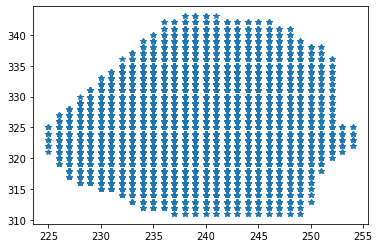

3D PLOT
3D PLOT with Sphere


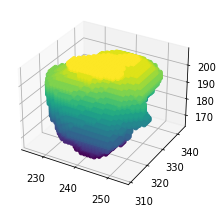

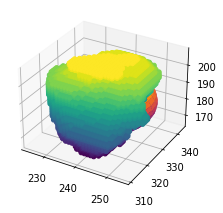

PET or CT image
None


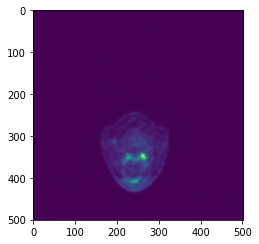

In [8]:
print(PLOT_DUMMY('P005'))

# Calculate various PET parameters for ALL patients

## Code to collect SUV.

In [9]:
# Function extracting SUVVALUES 
# From it we also obtain the Tumor volume.

def SUVExtractor(PatientNumber):
    PatientWithTumor = []  # Here I store patient with a primary tumor. 
    Part_readfile = '/volumes/LaCie/Sagal/HN_ANON_09102017/Patient_Folders/'
    strek ='/'
    file_raw = '_raw_data.txt'
    RawTextFile  = Part_readfile + PatientNumber + strek + PatientNumber + file_raw # Read in file
    Index_data = Func_Concat_Header_Array_Index_PT_CT(RawTextFile,Index_type='PT') # Extract index
    PET_VALUES = []
    for i in Index_data:
        for j in i:
            if j == 'Hi':
                pass
            else:
                PET_VALUES.append(j)
    # To chose correct array number FROM PET_VALUES, ARRAY NUM IS USED.
    try:
        ArrayName,ArrayNum,PatientWithTumor = CorrectTumorChoice(PatientNumber)     
        # Need to define a so that we chose the correct array
        a = 2*ArrayNum +1
        Pet_Values0 = PET_VALUES[a]
        PatientWithTumor.append(PatientNumber)
        return Pet_Values0
    except ValueError:
        pass

# Lese ut tumor verdi.
def SUV_samler(PatientName):
    SUVSAMLET = []
    for i in (PatientName):
        if i == 'P118': # Jumping over because it causes code to crash
            pass
        else:
            b = (SUVExtractor(i))
            a = np.array(b)
            SUVSAMLET.append(a)
    return SUVSAMLET

## Code to calculate PET parameters

In [10]:
# Extract SUVMEAN from SUV-values obtained from files. 
def SUVMEAN(SUV):
    SUVMEANLIST = []
    for i in SUV:
        a = np.mean(i)
        SUVMEANLIST.append(a)
    return SUVMEANLIST

# Extract SUVMAX from SUV-values obtained from files. 

def SUVMAXMINE(SUV):
    SUVMAXLIST = []
    for i in SUV:
        a = np.amax(i)
        SUVMAXLIST.append(a)
    return SUVMAXLIST

#Tumor volume from the length of the PET-values for each pasient. 
def TumorVolumeFunction(SUV):
    TumorVolume = []
    PatientNumber = []
    for i in SUV:
        a = len(i)/1000
        TumorVolume.append(a)
    return TumorVolume


def MTV(SUV):
    MTV = []
    SuvMaximum = SUVMAXMINE(SUV) # Maximum SUV for patients are stored here. 
    SUVPixelValue = [] # SUV-values greater than threshold are collected here. 
    SUVCOLLECTER = []
    for k, i in enumerate (SUV):
        SuvMaX  = SuvMaximum[k]
        Threshold = SuvMaX*0.41
        if Threshold < 2.5:
            Threshold = 2.5
        for j in  i:
            if j > Threshold:
                SUVPixelValue.append(j)
        SUVCOLLECTER.append(SUVPixelValue)
        SUVPixelValue = []

    for i in SUVCOLLECTER:
        if i == []:
            pass
        else:
            a = len(i)/1000
            MTV.append(a)
    return MTV


def TLG(SUV):
    SuvMean=SUVMEAN(SUV)
    TLG = []
    for i,j in enumerate (MTV(SUV)):
        tlg = j*SuvMean[i]
        TLG.append(tlg)
    return TLG

def center_SUV(SUV,PatientGroup):
    Index = find_Center_Index(PatientGroup)
    Centerr_SUV=[]
    for i,j in enumerate (SUV):
        centerr=Index[i]
        Centerr=SUV[centerr]
        Centerr_SUV.append(Center)
        return Centerr_SUV

## Read in HNC-patients, HPV positive and negative patients
- HPV-status is read from a file. Then the patients are classified accordingly.

In [11]:
# Function that stores all patient groups.
def allpatients():
    AllPatients = []
    for i in PatientWithTumors:
        for j in i:
            AllPatients.append(j)
    return AllPatients

# Function used to read in HPV file.
def ReadHPVSituation():
    df = pd.read_csv('hpv_group_all.csv',skiprows=0)
    a = df.iloc[:,1]
    HPV_Situation = a.to_numpy()
    b = df.iloc[:,0]
    NumberOfPatient=b.to_numpy()
    return HPV_Situation,NumberOfPatient

# Read out patientnumber from file
def HPVPatientNumber():
    HPV_Situation,NumberOfPatient = ReadHPVSituation()
    # Grupperer pasienter i HPV postive = 1, og negative = 0. 
    PatientnumbOne = []
    PatientnumbZero = []
    HPVSITUATION = []

    for i,j in enumerate(HPV_Situation):
        if j == 0:
            PatientnumbZero.append(NumberOfPatient[i])
        elif j == 1:
            HPVSITUATION.append(j)
            PatientnumbOne.append(NumberOfPatient[i])
    return PatientnumbZero,PatientnumbOne

PatientnumbZero,PatientnumbOne = HPVPatientNumber()

# Code that Adds P and necessary zeros before patient id
def ExtractionPationNumbersHPV(HPVPatientsRelation):
    List = []
    for i in HPVPatientsRelation:
        Standard = 'P'
        OneZero = '0'
        TwoZer0 = '00'
        a = int(i)
        digits = int(math.log10(a))+1 # Use this to code number of digits of 'i'
        if digits == 1:
            PatientNum = Standard + TwoZer0 + str(a)
        elif digits == 2:
            PatientNum = Standard + OneZero + str(a)
        else:
            PatientNum = Standard + str(a)
        List.append(PatientNum)

    return (List)

# Function removing patients that do not have a GTV
def FinalPatientNumberHPV(PatientnumbZero):
    PatientNumberHPV0list = ExtractionPationNumbersHPV(PatientnumbZero)
    PatientNumberList=[]
    PatientWithTumor = allpatients()
    for i in PatientWithTumor:
        for k in PatientNumberHPV0list:
            if k == i:
                PatientNumberList.append(i)
    return PatientNumberList


#PatientNumber for HPV negative pasients are saved here.
PatientNumbeRHPVZero = FinalPatientNumberHPV(PatientnumbZero)
#PatientNumber for HPV positive pasients are saved here.
PatientNumbeRHPVOne = FinalPatientNumberHPV(PatientnumbOne)
#All pasients are saved here
AllPasientNumbers = allpatients()

## Extract outcome, and also corresponding patient numbers.
- Outcomes Overall Survival and Freedom From Failure are extracted by reading in from a file.
- ECOG is also extracted from file
- TNM staging of the patients. 

In [12]:
# Different variables stores in excel paper. Each is given the column number it is read from.  
# ArrayNumber if pasient is not sick
Sykdomsfri = 90
#ArrayNumber if pasient survies
Survival = 79
#Alder
Ecog = 32
# TNM stage
TNM = 15

#Function that reads inn files:


def ReadInFiles(ArrayNumber):
    #Read in Data
    df = pd.read_excel('pasinfo.xls',skiprows=2)
    # Reading in Patient ID
    ab = df.iloc[:,0]
    # Read in over all survival.
    a = df.iloc[:,ArrayNumber]
    # Remove Nan from list
    #Pasient = ab[:254]
    #PasientId = ab[np.logical_not(np.isnan(ab))]
    PasientId = ab[:254]
    # Remove Nan from list
    OverAllSurvival = a[:254]
    #OverAllSurvival = a[np.logical_not(np.isnan(a))]
    return PasientId,OverAllSurvival




# Function to create Readable pasient numbers from PasientID
PasientID,OverAllSurvival=ReadInFiles(Sykdomsfri)


def Patien_List():
    Patient_List=[]
    for i in PasientID:
        Standard = 'P'
        OneZero = '0'
        TwoZer0 = '00'
        a = int(i)
        digits = int(math.log10(a))+1 # Use this to code number of digits of 'i'
        if digits == 1:
            PatientNum = Standard + TwoZer0 + str(a)
        elif digits == 2:
            PatientNum = Standard + OneZero + str(a)
        else:
            PatientNum = Standard + str(a)
        Patient_List.append(PatientNum)
    return Patient_List


# Create a function that can take in different groups of Pasient.
# Compare it to what is available in file
# Extract Outcome

def OutComeOfPatientList(PatientGroup,Ov):
    Utfall = []
    Pasienter = []
    Patient_List = Patien_List()
    for j in PatientGroup:
        for i,k in enumerate (Patient_List):
            if k == j:
                Pasienter.append(k)
                U = Ov[i]
                Utfall.append(U)
    return Utfall,Pasienter





# Below code compute the overall survival for patients. Binary outputs are gotten.
PasientID,OverAllSurvival_Surv=ReadInFiles(Survival)

# Utfall, og pasient nummer for 3 pasient grupper
Outcome_All_Surv,PasietNumbAll =OutComeOfPatientList(AllPasientNumbers,OverAllSurvival_Surv)
Outcome_HPVPOS_Surv,PasietNumbPOSS = OutComeOfPatientList(PatientNumbeRHPVOne,OverAllSurvival_Surv)
Outcome_HPVNEG_Surv,PasietNumbNEG = OutComeOfPatientList(PatientNumbeRHPVZero,OverAllSurvival_Surv)


PasientID,OverAllSurvival_Ecog=ReadInFiles(Ecog)
# ECOG, og pasient nummer for 3 pasient grupper
ECOG_ALL,PasietNumbAll = OutComeOfPatientList(AllPasientNumbers,OverAllSurvival_Ecog)
ECOG_HPVPOS,PasietNumbPOS = OutComeOfPatientList(PatientNumbeRHPVOne,OverAllSurvival_Ecog)
ECOG_HPVNEG,PasietNumbNEG = OutComeOfPatientList(PatientNumbeRHPVZero,OverAllSurvival_Ecog)


PasientID,OverAllSurvival_TNM=ReadInFiles(TNM)

# TNM, og pasient nummer for 3 pasient grupper
TNM_ALL,PasietNumbAll = OutComeOfPatientList(AllPasientNumbers,OverAllSurvival_TNM)
TNM_HPVPOS,PasietNumbPOS = OutComeOfPatientList(PatientNumbeRHPVOne,OverAllSurvival_TNM)
TNM_HPVNEG,PasietNumbNEG = OutComeOfPatientList(PatientNumbeRHPVZero,OverAllSurvival_TNM)

PasientID,OverAllSurvivals=ReadInFiles(Sykdomsfri)
# Utfall, og pasient nummer for 3 pasient grupper
Outcome_All,PasietNumbAll = OutComeOfPatientList(AllPasientNumbers,OverAllSurvivals)
Outcome_HPVPOS,PasietNumbPOS = OutComeOfPatientList(PatientNumbeRHPVOne,OverAllSurvivals)
Outcome_HPVNEG,PasietNumbNEG = OutComeOfPatientList(PatientNumbeRHPVZero,OverAllSurvivals)


'''# Extract SUV for 3 pasient groups
SUV_ALL = SUV_samler(PasietNumbAll)
SUV_HPVPOS = SUV_samler(PasietNumbPOS)
SUV_HPVNEG = SUV_samler(PasietNumbNEG)'''

# SUV for different patient groups are stored here. This saves computation time
# Dont need to repeat calculations each time. 
%store -r SUV_ALL
%store -r SUV_HPVPOS
%store -r SUV_HPVNEG

## DFS
- DFS is gotten by combining FFF and OS.
- Function calculating frequency is included as well.

In [13]:

# Function that creates DFS from Survival(OS) and Freedom From Failure(FFS)
def DFS_Outcome(Outcome_Sick,Outcome_Surv):
    Outcome=[]
    n = []
    for i,j in enumerate(Outcome_Sick):
        if j == Outcome_Surv[i]:
            Outcome.append(j)
        elif j == 1 and Outcome_Surv[i] == 0:
            Outcome.append(j)
        elif j == 0 and Outcome_Surv[i] == 1:
            n.append(Outcome_Surv[i])
            Outcome.append(Outcome_Surv[i])
    return Outcome

# DFS for three patient groups.
New_Outcome_DFS_All = DFS_Outcome(Outcome_All,Outcome_All_Surv)
New_Outcome_DFS_NEG = DFS_Outcome(Outcome_HPVNEG,Outcome_HPVNEG_Surv)
New_Outcome_DFS_POS = DFS_Outcome(Outcome_HPVPOS,Outcome_HPVPOS_Surv)

   

# Function that calculates the frequency of positve(1) and negative(0) outcomes
def Calcaulate_Frequency(Outcome):
    Zeros = []
    Ones = []
    for i in Outcome:
        if i == 1:
            Ones.append(1)
        else:
            Zeros.append(0)
    return len(Ones)/len(Outcome), len(Zeros)/len(Outcome), len(Ones), len(Zeros)
A,B,C,D = (Calcaulate_Frequency(New_Outcome_DFS_POS))
print('Negatives frequency',B)
print('Negatives',D)
print('Positives frequency',A)
print('Positives',C)

Negatives frequency 0.6823529411764706
Negatives 58
Positives frequency 0.3176470588235294
Positives 27


## All predictors are calculated or extracted.
- GTV, PET predictors and ECOG are present here for three patient groups.

In [14]:
#Calculate Tumor Volume for 3 pasient groups
TumorVolume_ALL = TumorVolumeFunction(SUV_ALL)
TumorVolume_POS = TumorVolumeFunction(SUV_HPVPOS)
TumorVolume_NEG = TumorVolumeFunction(SUV_HPVNEG)

# Calculate Max SUV for 3 pasient groups
SUVMAX_ALL = SUVMAXMINE(SUV_ALL)
SUVMAX_POS = SUVMAXMINE(SUV_HPVPOS)
SUVMAX_NEG = SUVMAXMINE(SUV_HPVNEG)

# Calculate Max SUV for 3 pasient groups
SUVMEAN_ALL = SUVMEAN(SUV_ALL)
SUVMEAN_POS = SUVMEAN(SUV_HPVPOS)
SUVMEAN_NEG = SUVMEAN(SUV_HPVNEG)

#Calculate MTV FOR 3 PasientGroups
MTV_ALL = MTV(SUV_ALL)
MTV_POS = MTV(SUV_HPVPOS)
MTV_NEG = MTV(SUV_HPVNEG)

#Calculate TLG FOR 3 PasientGroups
TLG_ALL = TLG(SUV_ALL)
TLG_POS = TLG(SUV_HPVPOS)
TLG_NEG = TLG(SUV_HPVNEG)

# Ecog
ECOG_ALL = ECOG_ALL
ECOG_POS = ECOG_HPVPOS
ECOG_NEG = ECOG_HPVNEG

In [15]:
# Function below calculates the mean and median for predictors.
def Mean_Median(Ouput,Predictor):
    zeros=[]
    ones = []
    for i, j in enumerate(Ouput):
        if j == 0:
            zeros.append(Predictor[i])
        else:
            ones.append(Predictor[i])
    print('For zeros mean',np.mean(zeros))
    print('For ones mean',np.mean(ones))
    print('Difference mean',np.mean(ones)-np.mean(zeros))
    print('For zeros median',np.median(zeros))
    print('For ones median',np.median(ones))
    print('Difference median',np.median(ones)-np.median(zeros))
        


print(np.median(MTV_ALL[10]))


3.422


### GTV and MTV predictors are saved for 3 pasient groups

In [16]:
# Tumor Volume predictors for 3 pasient groups
X_ALL_GTV = np.array(np.ravel(TumorVolume_ALL).reshape(-1,1))
X_HPVPOS_GTV = np.array(np.ravel(TumorVolume_POS).reshape(-1,1))
X_HPVNEG_GTV = np.array(np.ravel(TumorVolume_NEG).reshape(-1,1))
# MTV predictors for 3 pasient groups
X_ALL_MTV = np.array(np.ravel(MTV_ALL).reshape(-1,1))
X_HPVPOS_MTV = np.array(np.ravel(MTV_POS).reshape(-1,1))
X_HPVNEG_MTV = np.array(np.ravel(MTV_NEG).reshape(-1,1))
# TLG predictors for 3 pasient groups
X_ALL_TLG = np.array(np.ravel(TLG_ALL).reshape(-1,1))
X_HPVPOS_TLG = np.array(np.ravel(TLG_POS).reshape(-1,1))
X_HPVNEG_TLG = np.array(np.ravel(TLG_NEG).reshape(-1,1))
# SUVMAX predictors for 3 pasient groups
X_ALL_SUVMAX = np.array(np.ravel(SUVMAX_ALL).reshape(-1,1))
X_HPVPOS_SUVMAX = np.array(np.ravel(SUVMAX_POS).reshape(-1,1))
X_HPVNEG_SUVMAX = np.array(np.ravel(SUVMAX_NEG).reshape(-1,1))
# SUVMEAN predictors for 3 pasient groups
X_ALL_SUVMEAN = np.array(np.ravel(SUVMEAN_ALL).reshape(-1,1))
X_HPVPOS_SUVMEAN = np.array(np.ravel(SUVMEAN_POS).reshape(-1,1))
X_HPVNEG_SUVMEAN = np.array(np.ravel(SUVMEAN_NEG).reshape(-1,1))
# Ecog predictors for 3 pasient groups
X_ALL_ECOG = np.array(np.ravel(ECOG_ALL).reshape(-1,1))
X_HPVPOS_ECOG = np.array(np.ravel(ECOG_POS).reshape(-1,1))
X_HPVNEG_ECOG = np.array(np.ravel(ECOG_NEG).reshape(-1,1))

# MT-Shell.
- Circle coordinates used to intersect with Tumor is created here.
- 436 Spheres are created. Ranging from radi = 0 to 900.

In [17]:
### I store it here, so that I dont need to run CircleCoordinates every time. It SAVES me time. 
# So, for now I will run for r = 900
from math import sqrt
def CircleCoordinates(RadiusLength):
    # Create arrays for x,y and z
    # Loop over and get possible whole coordinates from circle arrays x,y and z
    o=[] # Collects x,y and z that fullfil r**2=x**2+y**2+z**2
    P=[] # Collcects the coordinates, o.
    Radius = [ x for x in range(RadiusLength+2) if x % 1 == 0 and x<(401)]
    print(Radius)
    for i in (Radius):
        y,x,z = np.linspace(-i,i,2*i+1),np.linspace(-i,i,2*i+1),np.linspace(-i,i,2*i+1)
        for j in y:
            for k in x:
                for p in z:
                    if sqrt(j**2+k**2+p**2) == sqrt(i):
                        o.append(j)
                        o.append(k)
                        o.append(p)
        print(i)
        P.append(o)
        o=[]     
    # Group the different coordinates for each radius in 3 and 3.
    Final=[]
    for i in P:
        N = 3
        subList = [i[n:n+N] for n in range(0, len(i), N)]
        Final.append(subList)#%store CircleCoordinates400_600


    return Final

In [18]:
# They are stored here to save computation time.
# Dont need to calculate them for every singel patient. 
%store -r CircleCoordinates400_600
%store -r  CircleCoordinates600_900
%store -r CircleCoordinates0_400

In [19]:
# Circles are concatenated here.
circle = np.concatenate((CircleCoordinates0_400, CircleCoordinates400_600,CircleCoordinates600_900), axis=0)

- In the below codes tumor center is added to the sphere.
- Intersection with patient is then stored in an array.

In [20]:
# Make one function that extracts information about Patient. This cuts down computation time
def CenterXYZ(PatientNumber):
    Dummy,X,Y,Z = create_dummy_matrix(PatientNumber)
    Center_x =(np.amax(X)+np.amin(X))/2
    Center_y =(np.amax(Y)+np.amin(Y))/2
    Center_z =(np.amax(Z)+np.amin(Z))/2
    return Center_x,Center_y,Center_z,X,Y,Z


# Create a function that adds center of tumor
def Radius_Array(Center_x,Center_y,Center_z,Array):
    Ko = []
    for i,j in enumerate(Array):
        x = j[0]+int(Center_x)-1
        y = j[1]+int(Center_y)-1
        z = j[2]+int(Center_z)-1
        Ko.append(x)
        Ko.append(y)
        Ko.append(z)
    N = 3
    SubList = [Ko[n:n+N] for n in range(0, len(Ko), N)]

    return SubList

# This function finds out WHERE the sphere and the tumor actualy do intersect.
# This is done for every radius.
def intersect(array,X,Y,Z):
    index_list = []
    for i, j in enumerate(Z):
        x_values = X[i] # x-coordinate
        y_values = Y[i] # y-coordinate
        for å in array:#
            if å[0] == x_values and å[1] == y_values and å[2] == j:
                    index_list.append(i)
    return index_list


# This function runs over all sphere radiuses and adds tumor center using function radius_array
# Then it runs over all radius, and finds the intersection point each radius has with tumor.
# This is stored in array index_radiuses.
def RadiusTumorCenter(PatientNumber):
    Center_x,Center_y,Center_z,X,Y,Z = CenterXYZ(PatientNumber)
    Sphere_Coordinates = circle
    AddedTumorCenter=[]
    for i in Sphere_Coordinates:
        a = Radius_Array(Center_x,Center_y,Center_z,i)
        AddedTumorCenter.append(a)
    Index_Radiuses=[]
    for i in AddedTumorCenter:
        Index_Radius =  intersect(i,X,Y,Z)
        Index_Radiuses.append(Index_Radius)
    return Index_Radiuses

In [379]:
# Function that calculates mean SUV for EACH radius.
def Pet_mean_for_each_radius(Radius_Arrayy,Pet_Values):
    PET_values_intersections = []
    for i in Radius_Arrayy:
        u = Pet_Values[i]
        PET_values_intersections.append(u)
    MEANPET = np.mean(PET_values_intersections)
    return MEANPET

# Extract SUVMEAN from SUV-values obtained from files. 
def SUVMEAN(SUV):
    SUVMEANLIST = []
    for i in SUV:
        a = np.mean(i)
        SUVMEANLIST.append(a)
    return SUVMEANLIST


# This function calculates the MTV for EACH radius. 
def MTV_Sphere(ThresholdPercent,RadiusArray,PetPet_Values):
    PET_values_intersections = []
    SuvMaX = np.amax(PetPet_Values)
    Threshold = SuvMaX*ThresholdPercent
    if Threshold < 2.5:
            Threshold = 2.5
    else:
        Threshold = SuvMaX*ThresholdPercent
    SUVPixelValue = []
    for i in RadiusArray:
        u = PetPet_Values[i]
        if u > Threshold:
            PET_values_intersections.append(u)
    MEANPET = (PET_values_intersections)
    return len(MEANPET)

# This function sums up MTV to a certain radius

def MTV_Sphere_RADIUS(ThresholdPercent,RadiusArray,PetPet_Values):
    PET_values_intersections = []
    SuvMaX = np.amax(PetPet_Values)
    Threshold = SuvMaX*0.41
    if Threshold < 2.5:
            Threshold = 2.5
    else:
        Threshold = SuvMaX*ThresholdPercent
    SUVPixelValue = []
    for i in RadiusArray:
        u = PetPet_Values[i]
        if u > Threshold:
            PET_values_intersections.append(u)
    MEANPET = (PET_values_intersections)
    return len(MEANPET)


# Takes in the indexes given by RadiusTumorCenter function
# Brings out the PET values with those indexes, and calculate mean PET for every sphere going out.
def Read_Extract_PET(PatientNumber,ThresholdPercent):
    # Data is read in
    Part_readfile = '/volumes/LaCie/Sagal/HN_ANON_09102017/Patient_Folders/'
    strek ='/'
    file_text = '_info.txt'
    file_raw = '_raw_data.txt'
    InfoTextFile = Part_readfile + PatientNumber + strek + PatientNumber + file_text
    RawTextFile  = Part_readfile + PatientNumber + strek + PatientNumber + file_raw
    Index_data = Func_Concat_Header_Array_Index_PT_CT(RawTextFile,Index_type='PT')
    PET_VALUES = []
    # Do not remeber. But it is important
    for i in Index_data:
        for j in i:
            if j == 'Hi':
                pass
            else:
                PET_VALUES.append(j)
    # To chose correct array number FROM PET_VALUES, ARRAY NUM IS USED.
    ArrayName,ArrayNum,PatientWithTumor = CorrectTumorChoice(PatientNumber)
    # Need to define a so that we chose the correct array
    a = 2*ArrayNum +1
    Pet_Values0 = PET_VALUES[a]
    StoredPET = []
    Radius_Index_Array=RadiusTumorCenter(PatientNumber)

    for i in Radius_Index_Array:
        #b = Pet_mean_for_each_radius(i,Pet_Values0) # Mean PET calculated
        b = MTV_Sphere(ThresholdPercent,i,Pet_Values0)# Do this to exclude NaN # MTV for each radius calculated.
        if b <1000: # Do this to exclude NaN # MTV for each radius calculated.
            c = b
        else:
            c = 0
        StoredPET.append(c)
    return StoredPET





## Profile plot
- The profiles are plotted here. in the below code profiles with MTV havinf thresholds = 0.41 and 0 are included.

In [ ]:
# From function read_extract_pet there are zeros due to radius length included
# This function we use to remove those.
# Remember! You have removed Threshold.

def remove_zeros_end(PatientNumber,ThresholdPercent):
    PET_SUV = Read_Extract_PET(PatientNumber,ThresholdPercent)
    PETSUV=[]
    for i in PET_SUV[10:]:
        if i == 0:
            pass
        else:
            PETSUV.append(i)
    a = PET_SUV[:10]
    for i in PETSUV:
        a.append(i)

    return a  

# Use this code when you store PET_SUV_ALL
def plot_Patients_HPV_NEG(PatientNumber,PET_SUV,ThresholdPercent):
    # Y axis values
    y = PET_SUV
    # corresponding X axis values
    x = np.linspace(0,len(PET_SUV)/(len(PET_SUV)),len(PET_SUV))

    # plotting the points
    plt.plot(x, y,'*')

    # naming the x axis
    plt.xlabel('Radius in pixel')
    # naming the y axis
    plt.ylabel('SUV')

    # giving a title to my graph
    plt.title(PatientNumber)

    # function to show the plot
    plt.show()
    
    return PET_SUV

# Function below calculates the SUVMEAN as we increase in radius
def MeanRadius(PETSUVALL):    
    SUM = [] # Access suvmean for each radius for each patient
    mean = [] # These calculates the mean as we increase in radius
    MEAN=[] # Collects the mean for each patient.
    for j in PETSUVALL:
        for i in j:
            SUM.append(i)
            mean.append(np.mean(SUM))
        MEAN.append(mean)
        mean=[]
    return MEAN
#SUVBAR = MeanRadius(PET_SUV_ALL) 



# Function below extracts PET_SUV_ALL, but we have stored it. So we dont need to run it. 
# NOW, we shall run with our new r-values. We have added that we need 2500 points! Not 50.
# We have removed Threshold. 
def plot_Patients_HPV_NEG(PatientNumber,ThresholdPercent):
    PET_SUV = remove_zeros_end(PatientNumber,ThresholdPercent)
    # x axis values
    y = PET_SUV
    # corresponding y axis values
    x = np.linspace(0,len(PET_SUV)/(len(PET_SUV)),len(PET_SUV))


    # plotting the points
    plt.plot(x, y,'*')

    # naming the x axis
    plt.xlabel('Radius in pixel')
    # naming the y axis
    #plt.ylabel('SUV')
    plt.ylabel('Metabolic Tumor Shell')


    # giving a title to my graph
    plt.title(PatientNumber)

    # function to show the plot
    plt.show()
    
    return PET_SUV
# Run trough Thresholds
# Outcome_ALL,PasietNumbAll
PET_SUV_ALL_mtv=[]
Threshold = [0.41,0]
PET_SUV_ALL_MTV_Thresh = [] # Here the MTV for each radius for different thresholds are stored here.
for k in Threshold:
    for j,i in enumerate (PasietNumbNEG):
        print('Outcome',Outcome_HPVNEG[j])
        PET_SUV = plot_Patients_HPV_NEG(i,k)
        PET_SUV_ALL_mtv.append(PET_SUV)
    PET_SUV_ALL_MTV_Thresh.append(PET_SUV_ALL_mtv)
    PET_SUV_ALL_mtv = []


PET_SUV_ALL_MTV_Thresh_61_51_41_31_21_11 = PET_SUV_ALL_MTV_Thresh
%store PET_SUV_ALL_MTV_Thresh_61_51_41_31_21_11

## Interpolation
- The radiuses are interpolated to 2000 radiuses.
- Each radi is a variable. Due to that, plots of F1-score and AUC-score across radius are plotted.
- This is to visualize at what radius the logistic regression model perfoms at its best. 

In [21]:
'''Varius Radius Threshold are stored here.'''
#%store -r  PET_SUV_ALL_MTV_Thresh_61
#%store -r PET_SUV_ALL_MTV_Thresh_76_71_66
#%store -r PET_SUV_ALL_MTV_Thresh_96_91_86_81_56_51_46_41
#%store -r PET_SUV_ALL_MTV_Thresh_36_31_26_21_16_11_06_0
#%store -r PET_SUV_ALL_MTV_Thresh_41_0


%store -r PET_SUV_ALL_MTV_Thresh_41_0



# Threshold MTV 0.41 and 0 are present here.
A = PET_SUV_ALL_MTV_Thresh_41_0


# Here, different Thresholds are applied.
def Sphere_Processed(a):
    # Run trough and interpolate A
    PET_SUV_ALL_INTERP=[]
    Radius = np.linspace(0,1,437)
    base_radius = np.linspace(0, 1, 2000)
    for i in a:
        Radius = np.linspace(0,1,len(i))
        SUV_CENTER_INTERP = np.interp(base_radius, Radius, i)
        PET_SUV_ALL_INTERP.append(SUV_CENTER_INTERP)
    # Here, all sphere Radius interpolated are stored.
    # I run through PET_SUV_ALL_INTERP, and only extract first radius value
    # Add it to a list, and continue until I have Sphere_Radius_all which contains SUV for each radius length for all patients. 
    Sphere_Radius_all=[]
    for k in range(len(base_radius)):
        Sphere_Radius=[]
        for i,j in enumerate(PET_SUV_ALL_INTERP):
            a = j[k]
            Sphere_Radius.append(a)
        Sphere_Radius_all.append(Sphere_Radius)
        Sphere_Radius=[]



    # Here I prepare so that analysis can be performed. 
    Sphere_Radius_all_processed = []
    for i in Sphere_Radius_all:
        SphereRadius = np.array(np.ravel(i).reshape(-1,1))
        processed_SphereRadius = np.concatenate([SphereRadius],axis=1)
        Sphere_Radius_all_processed.append(processed_SphereRadius)
    return Sphere_Radius_all_processed
# MTV with threshold = 0.41 is chosen here.
Sphere_Radius_all_processes = Sphere_Processed(A[0])

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
def GridSearch(scoring,Output,split,Predictor):
    #define cross-validation method to use
    #cv = LeaveOneOut()
    #define cross-validation method to use
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    #logreg = SVC()
    # fit the model with data
    ypart = Output
    xpart = Predictor
    logreg.fit(xpart, ypart)
    penalty = ['l2','l1']
    parameters = dict(penalty=penalty)
    #parameters = { 
    #'C'       #: (C)}
    clf = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = scoring)
    clf.fit(xpart, ypart)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy:",clf.best_score_)
    return clf.best_score_



f1=[]
auc=[]
from sklearn.metrics import f1_score
for i,j in enumerate(Sphere_Radius_all_processes):
    print(i)
    logreg = LogisticRegression().fit(j, New_Outcome_DFS_NEG)
    ypred = logreg.predict(j)
    y_score = logreg.predict_proba(j)
    fpr, tpr, _ = roc_curve(New_Outcome_DFS_NEG, y_score[:, 1])
    AUC = metrics.auc(fpr, tpr)
    auc.append(AUC)
    f1_score = metrics.f1_score(New_Outcome_DFS_NEG, ypred, average='macro')
    f1.append(f1_score)
    print('F1-score',f1_score)
    print('AUC',AUC)



0
F1-score 0.4017094017094017
AUC 0.5841813135985199
1
F1-score 0.4017094017094017
AUC 0.4666975023126735
2
F1-score 0.4017094017094017
AUC 0.4666975023126735
3
F1-score 0.4017094017094017
AUC 0.4666975023126735
4
F1-score 0.4017094017094017
AUC 0.4666975023126735
5
F1-score 0.4017094017094017
AUC 0.4666975023126735
6
F1-score 0.4017094017094017
AUC 0.4690101757631822
7
F1-score 0.4017094017094017
AUC 0.47178538390379277
8
F1-score 0.4017094017094017
AUC 0.4727104532839963
9
F1-score 0.4017094017094017
AUC 0.47733580018501387
10
F1-score 0.4017094017094017
AUC 0.47548566142460685
11
F1-score 0.4017094017094017
AUC 0.481036077705828
12
F1-score 0.4017094017094017
AUC 0.5402405180388529
13
F1-score 0.4017094017094017
AUC 0.57631822386679
14
F1-score 0.4017094017094017
AUC 0.5957446808510638
15
F1-score 0.4017094017094017
AUC 0.6059204440333025
16
F1-score 0.4017094017094017
AUC 0.6096207215541165
17
F1-score 0.4017094017094017
AUC 0.6327474560592045
18
F1-score 0.396551724137931
AUC 0.63

F1-score 0.44683908045977017
AUC 0.5624421831637373
175
F1-score 0.44683908045977017
AUC 0.5925069380203516
176
F1-score 0.5535714285714286
AUC 0.5971322849213692
177
F1-score 0.5535714285714286
AUC 0.6091581868640148
178
F1-score 0.5868282075178628
AUC 0.6230342275670675
179
F1-score 0.5949074074074074
AUC 0.6378353376503237
180
F1-score 0.6233361653922401
AUC 0.6438482886216467
181
F1-score 0.5089285714285714
AUC 0.6225716928769658
182
F1-score 0.396551724137931
AUC 0.5966697502312674
183
F1-score 0.4017094017094017
AUC 0.5753931544865865
184
F1-score 0.4017094017094017
AUC 0.5485661424606846
185
F1-score 0.4017094017094017
AUC 0.509713228492137
186
F1-score 0.4017094017094017
AUC 0.5152636447733581
187
F1-score 0.4017094017094017
AUC 0.5309898242368177
188
F1-score 0.4017094017094017
AUC 0.5420906567992599
189
F1-score 0.4017094017094017
AUC 0.5328399629972248
190
F1-score 0.4017094017094017
AUC 0.5041628122109159
191
F1-score 0.4017094017094017
AUC 0.5263644773358003
192
F1-score 0

F1-score 0.4017094017094017
AUC 0.5180388529139687
328
F1-score 0.4017094017094017
AUC 0.5106382978723405
329
F1-score 0.4017094017094017
AUC 0.49861239592969475
330
F1-score 0.4017094017094017
AUC 0.5041628122109159
331
F1-score 0.4017094017094017
AUC 0.513413506012951
332
F1-score 0.4017094017094017
AUC 0.5208140610545791
333
F1-score 0.4017094017094017
AUC 0.5374653098982423
334
F1-score 0.4017094017094017
AUC 0.5420906567992599
335
F1-score 0.4017094017094017
AUC 0.5559666975023128
336
F1-score 0.4017094017094017
AUC 0.5689176688251618
337
F1-score 0.4017094017094017
AUC 0.5670675300647549
338
F1-score 0.4017094017094017
AUC 0.5596669750231267
339
F1-score 0.5433364398881639
AUC 0.5846438482886216
340
F1-score 0.5649600473512874
AUC 0.5827937095282146
341
F1-score 0.5757575757575758
AUC 0.5735430157261794
342
F1-score 0.5757575757575758
AUC 0.5758556891766883
343
F1-score 0.5535714285714286
AUC 0.5781683626271971
344
F1-score 0.5276653171390013
AUC 0.5550416281221091
345
F1-score 0

F1-score 0.4017094017094017
AUC 0.5587419056429233
549
F1-score 0.4017094017094017
AUC 0.5383903792784459
550
F1-score 0.4017094017094017
AUC 0.49213691026827017
551
F1-score 0.4017094017094017
AUC 0.5161887141535615
552
F1-score 0.44683908045977017
AUC 0.5337650323774283
553
F1-score 0.5276653171390013
AUC 0.5300647548566142
554
F1-score 0.5276653171390013
AUC 0.5226641998149861
555
F1-score 0.4017094017094017
AUC 0.517113783533765
556
F1-score 0.4017094017094017
AUC 0.513413506012951
557
F1-score 0.4017094017094017
AUC 0.5050878815911193
558
F1-score 0.4017094017094017
AUC 0.5226641998149861
559
F1-score 0.4017094017094017
AUC 0.5402405180388529
560
F1-score 0.4017094017094017
AUC 0.5615171137835338
561
F1-score 0.4017094017094017
AUC 0.5661424606845513
562
F1-score 0.4017094017094017
AUC 0.5781683626271971
563
F1-score 0.4017094017094017
AUC 0.5753931544865865
564
F1-score 0.4017094017094017
AUC 0.5707678075855689
565
F1-score 0.4017094017094017
AUC 0.5541165587419057
566
F1-score 0

F1-score 0.4017094017094017
AUC 0.5328399629972248
709
F1-score 0.4017094017094017
AUC 0.545790934320074
710
F1-score 0.4017094017094017
AUC 0.572617946345976
711
F1-score 0.4017094017094017
AUC 0.6170212765957447
712
F1-score 0.4017094017094017
AUC 0.6392229417206291
713
F1-score 0.4017094017094017
AUC 0.6364477335800185
714
F1-score 0.4017094017094017
AUC 0.6327474560592045
715
F1-score 0.4017094017094017
AUC 0.6225716928769658
716
F1-score 0.4017094017094017
AUC 0.6253469010175763
717
F1-score 0.4017094017094017
AUC 0.6031452358926919
718
F1-score 0.4017094017094017
AUC 0.5827937095282145
719
F1-score 0.4017094017094017
AUC 0.5568917668825162
720
F1-score 0.4017094017094017
AUC 0.5356151711378354
721
F1-score 0.4017094017094017
AUC 0.5291396854764108
722
F1-score 0.4017094017094017
AUC 0.48751156336725254
723
F1-score 0.4017094017094017
AUC 0.49491211840888066
724
F1-score 0.4017094017094017
AUC 0.5097132284921368
725
F1-score 0.4017094017094017
AUC 0.5106382978723405
726
F1-score 0

F1-score 0.4017094017094017
AUC 0.666049953746531
859
F1-score 0.4017094017094017
AUC 0.6493987049028677
860
F1-score 0.4017094017094017
AUC 0.639222941720629
861
F1-score 0.4017094017094017
AUC 0.6262719703977798
862
F1-score 0.4017094017094017
AUC 0.6003700277520814
863
F1-score 0.4017094017094017
AUC 0.5883441258094357
864
F1-score 0.4017094017094017
AUC 0.5652173913043479
865
F1-score 0.4017094017094017
AUC 0.5531914893617021
866
F1-score 0.4017094017094017
AUC 0.5531914893617021
867
F1-score 0.4017094017094017
AUC 0.606845513413506
868
F1-score 0.4017094017094017
AUC 0.6382978723404255
869
F1-score 0.4017094017094017
AUC 0.6716003700277521
870
F1-score 0.5276653171390013
AUC 0.6817761332099908
871
F1-score 0.5181907571288101
AUC 0.6827012025901943
872
F1-score 0.5181907571288101
AUC 0.6854764107308049
873
F1-score 0.4804318488529014
AUC 0.6771507863089731
874
F1-score 0.4804318488529014
AUC 0.6817761332099906
875
F1-score 0.4017094017094017
AUC 0.669750231267345
876
F1-score 0.401

F1-score 0.4017094017094017
AUC 0.635522664199815
1090
F1-score 0.4017094017094017
AUC 0.635522664199815
1091
F1-score 0.4017094017094017
AUC 0.6308973172987975
1092
F1-score 0.4017094017094017
AUC 0.6271970397779834
1093
F1-score 0.4017094017094017
AUC 0.635522664199815
1094
F1-score 0.4017094017094017
AUC 0.646623496762257
1095
F1-score 0.4017094017094017
AUC 0.6706753006475487
1096
F1-score 0.44683908045977017
AUC 0.6938020351526364
1097
F1-score 0.5757575757575758
AUC 0.7123034227567067
1098
F1-score 0.6233361653922401
AUC 0.7252543940795559
1099
F1-score 0.638095238095238
AUC 0.7298797409805735
1100
F1-score 0.5433364398881639
AUC 0.7086031452358926
1101
F1-score 0.5276653171390013
AUC 0.6956521739130435
1102
F1-score 0.44683908045977017
AUC 0.6780758556891767
1103
F1-score 0.4017094017094017
AUC 0.6493987049028678
1104
F1-score 0.4017094017094017
AUC 0.629972247918594
1105
F1-score 0.4017094017094017
AUC 0.6262719703977798
1106
F1-score 0.4017094017094017
AUC 0.6123959296947271
1

F1-score 0.4017094017094017
AUC 0.650786308973173
1246
F1-score 0.4017094017094017
AUC 0.6406105457909343
1247
F1-score 0.4017094017094017
AUC 0.6429232192414431
1248
F1-score 0.4017094017094017
AUC 0.6456984273820536
1249
F1-score 0.4017094017094017
AUC 0.6207215541165588
1250
F1-score 0.4017094017094017
AUC 0.6234967622571693
1251
F1-score 0.4017094017094017
AUC 0.6271970397779834
1252
F1-score 0.4017094017094017
AUC 0.6281221091581869
1253
F1-score 0.4017094017094017
AUC 0.6234967622571693
1254
F1-score 0.4017094017094017
AUC 0.6336725254394079
1255
F1-score 0.4017094017094017
AUC 0.637372802960222
1256
F1-score 0.4017094017094017
AUC 0.6290471785383904
1257
F1-score 0.4017094017094017
AUC 0.6281221091581869
1258
F1-score 0.4017094017094017
AUC 0.6410730804810361
1259
F1-score 0.4017094017094017
AUC 0.6558741905642923
1260
F1-score 0.4017094017094017
AUC 0.6679000925069379
1261
F1-score 0.4017094017094017
AUC 0.6780758556891767
1262
F1-score 0.4017094017094017
AUC 0.6577243293246993

F1-score 0.5726970033296337
AUC 0.7049028677150788
1398
F1-score 0.5512820512820513
AUC 0.7160037002775209
1399
F1-score 0.5512820512820513
AUC 0.7113783533765032
1400
F1-score 0.5619047619047619
AUC 0.7039777983348752
1401
F1-score 0.5836873406966865
AUC 0.6975023126734505
1402
F1-score 0.4804318488529014
AUC 0.664199814986124
1403
F1-score 0.5535714285714286
AUC 0.6771507863089732
1404
F1-score 0.4017094017094017
AUC 0.667900092506938
1405
F1-score 0.4017094017094017
AUC 0.6614246068455134
1406
F1-score 0.4017094017094017
AUC 0.6484736355226642
1407
F1-score 0.4017094017094017
AUC 0.6456984273820536
1408
F1-score 0.4017094017094017
AUC 0.6419981498612396
1409
F1-score 0.4017094017094017
AUC 0.6271970397779834
1410
F1-score 0.4017094017094017
AUC 0.6225716928769658
1411
F1-score 0.4017094017094017
AUC 0.635522664199815
1412
F1-score 0.4017094017094017
AUC 0.6567992599444958
1413
F1-score 0.4017094017094017
AUC 0.6891766882516188
1414
F1-score 0.4017094017094017
AUC 0.691026827012026
1

F1-score 0.5757575757575758
AUC 0.7012025901942646
1557
F1-score 0.5535714285714286
AUC 0.6993524514338575
1558
F1-score 0.5276653171390013
AUC 0.6933395004625348
1559
F1-score 0.48869565217391303
AUC 0.6868640148011101
1560
F1-score 0.48869565217391303
AUC 0.6877890841813137
1561
F1-score 0.4017094017094017
AUC 0.6850138760407032
1562
F1-score 0.4017094017094017
AUC 0.6831637372802961
1563
F1-score 0.4017094017094017
AUC 0.6803885291396855
1564
F1-score 0.4017094017094017
AUC 0.6887141535615171
1565
F1-score 0.4017094017094017
AUC 0.7086031452358927
1566
F1-score 0.4017094017094017
AUC 0.7035152636447732
1567
F1-score 0.4017094017094017
AUC 0.7044403330249769
1568
F1-score 0.44
AUC 0.7002775208140611
1569
F1-score 0.5535714285714286
AUC 0.6975023126734505
1570
F1-score 0.5535714285714286
AUC 0.6836262719703978
1571
F1-score 0.5433364398881639
AUC 0.683163737280296
1572
F1-score 0.5089285714285714
AUC 0.6998149861239592
1573
F1-score 0.4017094017094017
AUC 0.6526364477335801
1574
F1-sc

F1-score 0.4017094017094017
AUC 0.7067530064754857
1724
F1-score 0.4017094017094017
AUC 0.7178538390379279
1725
F1-score 0.4017094017094017
AUC 0.7317298797409806
1726
F1-score 0.4017094017094017
AUC 0.7368177613320999
1727
F1-score 0.4017094017094017
AUC 0.7395929694727104
1728
F1-score 0.44
AUC 0.7479185938945421
1729
F1-score 0.6629849900877938
AUC 0.7548566142460684
1730
F1-score 0.6723330869672333
AUC 0.7594819611470862
1731
F1-score 0.6354166666666666
AUC 0.7687326549491211
1732
F1-score 0.668560606060606
AUC 0.7636447733580018
1733
F1-score 0.65
AUC 0.7664199814986123
1734
F1-score 0.65
AUC 0.7645698427382054
1735
F1-score 0.6761904761904762
AUC 0.7516188714153562
1736
F1-score 0.44683908045977017
AUC 0.7298797409805734
1737
F1-score 0.4017094017094017
AUC 0.7039777983348752
1738
F1-score 0.4017094017094017
AUC 0.6956521739130435
1739
F1-score 0.4017094017094017
AUC 0.6827012025901943
1740
F1-score 0.4017094017094017
AUC 0.6614246068455134
1741
F1-score 0.4017094017094017
AUC 0.

F1-score 0.6354166666666667
AUC 0.7747456059204441
1884
F1-score 0.6063924237940219
AUC 0.7886216466234968
1885
F1-score 0.7008547008547008
AUC 0.786308973172988
1886
F1-score 0.7334348819497334
AUC 0.7909343200740055
1887
F1-score 0.7334348819497334
AUC 0.7853839037927843
1888
F1-score 0.7110423116615068
AUC 0.780758556891767
1889
F1-score 0.5757575757575758
AUC 0.7715078630897317
1890
F1-score 0.4017094017094017
AUC 0.7650323774283072
1891
F1-score 0.4017094017094017
AUC 0.7409805735430157
1892
F1-score 0.4017094017094017
AUC 0.7298797409805735
1893
F1-score 0.4017094017094017
AUC 0.7243293246993525
1894
F1-score 0.4017094017094017
AUC 0.7206290471785385
1895
F1-score 0.4017094017094017
AUC 0.7123034227567068
1896
F1-score 0.5333333333333333
AUC 0.7160037002775209
1897
F1-score 0.6260683760683761
AUC 0.7243293246993524
1898
F1-score 0.6
AUC 0.7169287696577242
1899
F1-score 0.5440385160011328
AUC 0.7298797409805735
1900
F1-score 0.5235276709085528
AUC 0.7391304347826086
1901
F1-score 

In [22]:
# Then, those with F1-score greater than 0.75 are thresholded. For MTV with threshold = 0.41 there is none. 
Sphere_Significant = []
radius_chosen=[]
a = np.amax(f1)
for j,i in enumerate (f1):
    if i >= 0.75:
        radius_chosen.append(j)
        Sphere_Significant.append(Sphere_Radius_all_processes[j])
        
print(len(Sphere_Significant))    

0


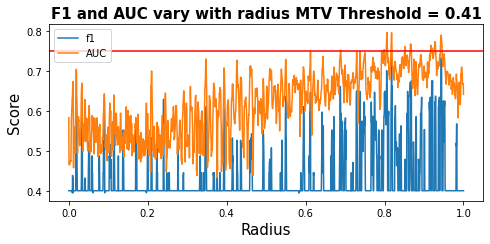

In [23]:
base_radius = np.linspace(0, 1, 2000)
plt.figure()
plt.plot(base_radius,f1,label='f1')
plt.plot(base_radius,auc,label='AUC')
plt.xlabel('Radius',fontsize=15)
plt.ylabel('Score',fontsize=15)
plt.axhline(y = 0.75, color='r',linestyle='-')
plt.title('F1 and AUC vary with radius MTV Threshold = 0.41',fontsize=15,fontweight='bold')
plt.legend()
plt.show()



## Split of data. Also deciding on features.
- This codes all predictors are made easy callable.
- Also, a multivariate model is included in the code.

In [24]:
from sklearn.model_selection import train_test_split
# GTV DATA
processed_Data_All_GTV = np.concatenate([X_ALL_GTV],axis=1)
processed_Data_HPVPOS_GTV = np.concatenate([X_HPVPOS_GTV],axis=1)
processed_Data_HPVNEG_GTV = np.concatenate([X_HPVNEG_GTV],axis=1)

#SUV MAX DATA
processed_Data_All_SUVMAX = np.concatenate([X_ALL_SUVMAX],axis=1)
processed_Data_HPVPOS_SUVMAX = np.concatenate([X_HPVPOS_SUVMAX],axis=1)
processed_Data_HPVNEG_SUVMAX = np.concatenate([X_HPVNEG_SUVMAX],axis=1)

#SUV MEAN DATA
processed_Data_All_SUVMEAN = np.concatenate([X_ALL_SUVMEAN],axis=1)
processed_Data_HPVPOS_SUVMEAN = np.concatenate([X_HPVPOS_SUVMEAN],axis=1)
processed_Data_HPVNEG_SUVMEAN = np.concatenate([X_HPVNEG_SUVMEAN],axis=1)

# MTV DATA
processed_Data_All_MTV = np.concatenate([X_ALL_MTV],axis=1)
processed_Data_HPVPOS_MTV = np.concatenate([X_HPVPOS_MTV],axis=1)
processed_Data_HPVNEG_MTV = np.concatenate([X_HPVNEG_MTV],axis=1)

# TLG DATA
processed_Data_All_TLG = np.concatenate([X_ALL_TLG],axis=1)
processed_Data_HPVPOS_TLG = np.concatenate([X_HPVPOS_TLG],axis=1)
processed_Data_HPVNEG_TLG = np.concatenate([X_HPVNEG_TLG],axis=1)

# ECOG DATA
processed_Data_All_ECOG = np.concatenate([X_ALL_ECOG],axis=1)
processed_Data_HPVPOS_ECOG = np.concatenate([X_HPVPOS_ECOG],axis=1)
processed_Data_HPVNEG_ECOG = np.concatenate([X_HPVNEG_ECOG],axis=1)



# Best Best_Sphere_Radius_all_processed

Sphere_Radius_all_processes = Sphere_Significant



def AllData(Input,Predictor,k):
    if  Input == 'NEG' and Predictor == 'GTV':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart = (processed_Data_HPVNEG_GTV)
    elif Input == 'NEG' and Predictor == 'MTV':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1)) 
        xpart = (processed_Data_HPVNEG_MTV)
    elif Input == 'NEG' and Predictor == 'SUVMAX':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart = (processed_Data_HPVNEG_SUVMAX)
    elif Input == 'NEG' and Predictor == 'SUVMEAN':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart = (processed_Data_HPVNEG_SUVMEAN)
    elif Input == 'NEG' and Predictor == 'TLG':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart = (processed_Data_HPVNEG_TLG)
    elif Input == 'NEG' and Predictor == 'ECOG':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart = (processed_Data_HPVNEG_ECOG)
    elif Input == 'NEG' and Predictor == 'SUVSphere':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart = (Sphere_Radius_all_processes[k])
    elif Input == 'NEG' and Predictor == 'ECOG+TLG' :
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))        
        xpart1 = (processed_Data_HPVNEG_TLG)
        xpart2 = (processed_Data_HPVNEG_ECOG)
    elif Input == 'NEG' and Predictor == 'ECOG+MTV' :
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))        
        xpart1 = (processed_Data_HPVNEG_MTV)
        xpart2 = (processed_Data_HPVNEG_ECOG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'NEG' and Predictor == 'ECOG+GTV' :
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))        
        xpart1 = (processed_Data_HPVNEG_GTV)
        xpart2 = (processed_Data_HPVNEG_ECOG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'NEG' and Predictor == 'ECOG+TLG' :
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))        
        xpart1 = (processed_Data_HPVNEG_TLG)
        xpart2 = (processed_Data_HPVNEG_ECOG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'POS' and Predictor == 'GTV' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))      
        xpart = (processed_Data_HPVPOS_GTV)
    elif Input == 'POS' and Predictor == 'MTV' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart = (processed_Data_HPVPOS_MTV)
    elif Input == 'POS' and Predictor == 'SUVMAX' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart = (processed_Data_HPVPOS_SUVMAX)
    elif Input == 'POS' and Predictor == 'SUVMEAN' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart = (processed_Data_HPVPOS_SUVMEAN)
    elif Input == 'POS' and Predictor == 'TLG' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart = (processed_Data_HPVPOS_TLG)
    elif Input == 'POS' and Predictor == 'ECOG' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart = (processed_Data_HPVPOS_ECOG)
    elif Input == 'POS' and Predictor == 'MTV+GTV' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart1 = (processed_Data_HPVPOS_MTV)
        xpart2 = (processed_Data_HPVPOS_GTV)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'POS' and Predictor == 'MTV+TLG' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart1 = (processed_Data_HPVPOS_MTV)
        xpart2 = (processed_Data_HPVPOS_TLG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'POS' and Predictor == 'GTV+TLG' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart1 = (processed_Data_HPVPOS_GTV)
        xpart2 = (processed_Data_HPVPOS_TLG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'POS' and Predictor == 'ECOG+TLG' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart1 = (processed_Data_HPVPOS_ECOG)
        xpart2 = (processed_Data_HPVPOS_TLG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'POS' and Predictor == 'ECOG+GTV' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart1 = (processed_Data_HPVPOS_ECOG)
        xpart2 = (processed_Data_HPVPOS_GTV)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'POS' and Predictor == 'ECOG+MTV' :
        ypart = (np.ravel(New_Outcome_DFS_POS).reshape(-1,1))        
        xpart1 = (processed_Data_HPVPOS_ECOG)
        xpart2 = (processed_Data_HPVPOS_MTV)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'All' and Predictor == 'GTV' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart =(processed_Data_All_GTV)
    elif Input == 'All' and Predictor == 'MTV' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart=(processed_Data_All_MTV)
    elif Input == 'All' and Predictor == 'SUVMAX' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart = (processed_Data_All_SUVMAX)
    elif Input == 'All' and Predictor == 'SUVMEAN' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart = (processed_Data_All_SUVMEAN)
    elif Input == 'All' and Predictor == 'TLG' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart = (processed_Data_All_TLG)
    elif Input == 'All' and Predictor == 'ECOG' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart = (processed_Data_All_ECOG)
    elif Input == 'All' and Predictor == 'ECOG+MTV' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart1 = (processed_Data_All_ECOG)
        xpart2 = (processed_Data_All_MTV)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'All' and Predictor == 'ECOG+GTV' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart1 = (processed_Data_All_ECOG)
        xpart2 = (processed_Data_All_GTV)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'All' and Predictor == 'ECOG+TLG' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart1 = (processed_Data_All_ECOG)
        xpart2 = (processed_Data_All_TLG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'All' and Predictor == 'MTV+GTV' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart1 = (processed_Data_All_MTV)
        xpart2 = (processed_Data_All_GTV)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'All' and Predictor == 'MTV+TLG' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart1 = (processed_Data_All_MTV)
        xpart2 = (processed_Data_All_TLG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'All' and Predictor == 'GTV+TLG' :
        ypart = (np.ravel(New_Outcome_DFS_All).reshape(-1,1))
        xpart1 = (processed_Data_All_GTV)
        xpart2 = (processed_Data_All_TLG)
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'NEG' and Predictor == 'SUVSphere+GTV':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart1 = (processed_Data_HPVNEG_GTV)
        xpart2 = Sphere_Radius_all_processes[k]
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'NEG' and Predictor == 'SUVSphere+MTV':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart1 = (processed_Data_HPVNEG_MTV)
        xpart2 = Sphere_Radius_all_processes[k]
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'NEG' and Predictor == 'SUVSphere+TLG':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart1 = (processed_Data_HPVNEG_TLG)
        xpart2 = Sphere_Radius_all_processes[k]
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'NEG' and Predictor == 'SUVSphere+SUVMEAN':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart1 = (processed_Data_HPVNEG_SUVMEAN)
        xpart2 = Sphere_Radius_all_processes[k]
        xpart = np.concatenate((xpart1, xpart2), axis=1)
        xpart = np.concatenate((xpart1, xpart2,xpart3), axis=1)
    elif Input == 'NEG' and Predictor == 'ECOG+SUVSphere':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart1 = (Sphere_Radius_all_processes[k])
        xpart2 = processed_Data_HPVNEG_ECOG
        xpart = np.concatenate((xpart1, xpart2), axis=1)
    elif Input == 'NEG' and Predictor == 'ECOG+MTV+SUVSphere':
        ypart = (np.ravel(New_Outcome_DFS_NEG).reshape(-1,1))
        xpart1 = (processed_Data_HPVNEG_MTV)
        xpart2 = processed_Data_HPVNEG_ECOG
        xpart3 = (Sphere_Radius_all_processes[k])
        xpart = np.concatenate((xpart1, xpart2,xpart3), axis=1)
    return ypart,xpart


# Function that perfoms LOOCV
- Metrics F1 macro, accuracy and balanced accuracy are calculated using LOOCV.
- Also, the threshold is varied between 0 and 1 to find optimal threshold.

In [25]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,recall_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.metrics import roc_curve, auc



# Function below performs LOOCV. Accuracy, Recall and F1-SCORE macro are calculated with LOOCV
def Leave_One_Out(OUTCOME,PREDICTOR,k):   
    # create dataset
    y,X = AllData(OUTCOME,PREDICTOR,k)
    #YY=Thresh_Logistic('NEG','GTV',2)
    # create loocv procedure
    cv = LeaveOneOut()
    # enumerate splits
    Coeff = []
    y_true, y_pred = list(), list()
    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        # fit model
        model = LogisticRegression()
        model.fit(X_train, y_train)
        t=(np.exp(model.coef_))
        Coeff.append(t)
        # evaluate model
        yhat = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        # store
        y_true.append(y_test[0])
        y_pred.append(y_score[:, 1][0])

    b=[]
    a=[]
    Best = 0
    Threshold = np.linspace(0,1,num=201)
    thres = []
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    AUC = auc(fpr, tpr)
    #print('AUC for whole dataset',AUC)
    plt.plot(fpr, tpr, 'r', alpha=1,linewidth=3)
    
    for i in Threshold:
        thres.append(i)
        for j in y_pred:
            if j <i:
                a.append(0)
            else:
                a.append(1)
        b.append(a)
        a = []
    Best = 0
    for j, i in enumerate (b):
        accuracy = accuracy_score(i,y_true)
        f2 = f1_score(i, y_true,average='macro')
        BALANCED_best = balanced_accuracy_score(i, y_true)
        recall = recall_score(i,y,average=None)
        ar = (f2+BALANCED_best+accuracy)
        if  Best <(ar) and accuracy !=BALANCED_best:
            Best = ar
            accuracy_best = accuracy_score(i, y_true)
            recall_best = recall_score(i,y,average=(None))
            AccuracyBalance_best = balanced_accuracy_score(i, y_true)
            Threshold_best = Threshold[j]
            F1_MACRO_BEST = f1_score(i, y_true,average='macro')
        else:
            pass
            #print('Ignore')
    #print('Accuracy is',accuracy_best)
    #print('Balanced Accuracy',AccuracyBalance_best)
    #print('F1_score is',F1_MACRO_BEST)
    #print('Threshold',Threshold_best)
    #print('Recall',recall_best)
    return accuracy_best,AccuracyBalance_best,F1_MACRO_BEST,recall_best,Threshold_best
    
            





# Function below helps me choose the BEST SUVsphere
def ChoseBestSuvSphere(Predictor,Length):
    Best = 0
    for i in range(Length):
        accuracy_best_Suv,AccuracyBalance_best,f1_macro_best_Suv,recall_best_Suv,Threshold_best_Suv=Leave_One_Out('NEG',Predictor,i)
        ar = (f1_macro_best_Suv+accuracy_best_Suv+AccuracyBalance_best) 
        if Best < ar:
            Best = ar
            accuracy_best_Suvv = accuracy_best_Suv
            recall_best_Suvv = recall_best_Suv
            f1_macro_best_Suvv = f1_macro_best_Suv
            Threshold_best_Suvv = Threshold_best_Suv
            Balanced_Accc = AccuracyBalance_best
            Best_Radiuss = radius_chosen[i]
            best_num = i
    print('Number',best_num)
    return accuracy_best_Suvv,Balanced_Accc,f1_macro_best_Suvv,recall_best_Suvv,Threshold_best_Suvv,Best_Radiuss

'''Length = len(Sphere_Radius_all_processes)
accuracy_best_Suv,AccuracyBalance_best,f1_macro_best_Suv,recall_best_Suv,Threshold_best_Suv,Best_Radius =ChoseBestSuvSphere('SUVSphere',Length)
print('Accuracy',accuracy_best_Suv)
print('Recall',recall_best_Suv)
print('F1-macro',f1_macro_best_Suv)
print('Threshold',Threshold_best_Suv)
print('Radius',Best_Radius)
print('Balanced Accuracy',AccuracyBalance_best)

accuracy_best_Suv,AccuracyBalance_best,f1_macro_best_Suv,recall_best_Suv,Threshold_best_Suv,Best_Radius =ChoseBestSuvSphere('ECOG+SUVSphere',4)
print('Accuracy',accuracy_best_Suv)
print('Recall',recall_best_Suv)
print('F1-macro',f1_macro_best_Suv)
print('Threshold',Threshold_best_Suv)
print('Radius',Best_Radius)
print('Balanced Accuracy',AccuracyBalance_best)'''

"Length = len(Sphere_Radius_all_processes)\naccuracy_best_Suv,AccuracyBalance_best,f1_macro_best_Suv,recall_best_Suv,Threshold_best_Suv,Best_Radius =ChoseBestSuvSphere('SUVSphere',Length)\nprint('Accuracy',accuracy_best_Suv)\nprint('Recall',recall_best_Suv)\nprint('F1-macro',f1_macro_best_Suv)\nprint('Threshold',Threshold_best_Suv)\nprint('Radius',Best_Radius)\nprint('Balanced Accuracy',AccuracyBalance_best)\n\naccuracy_best_Suv,AccuracyBalance_best,f1_macro_best_Suv,recall_best_Suv,Threshold_best_Suv,Best_Radius =ChoseBestSuvSphere('ECOG+SUVSphere',4)\nprint('Accuracy',accuracy_best_Suv)\nprint('Recall',recall_best_Suv)\nprint('F1-macro',f1_macro_best_Suv)\nprint('Threshold',Threshold_best_Suv)\nprint('Radius',Best_Radius)\nprint('Balanced Accuracy',AccuracyBalance_best)"

## Sigmoid function for predictors used in model
- Sigmoid function thresholded with optimal threshold is plotted here.
- Coloring is added to see wrongly, and correctly classified outputs.
- Wrong = red. Correct = Green.

Correctly classified 0.6285714285714286
Wrongly classified 0.37142857142857144


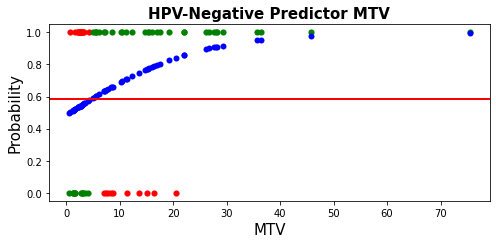

In [29]:
y, X = AllData('NEG','MTV',4)
clf = LogisticRegression().fit(X, y)
# Creating sample Z points



z = np.dot(X,clf.coef_.T)+clf.intercept_
phi_z = sigmoid(z)
color = []
right = []
wrong = []
for i, j in enumerate(phi_z):
    #Correct Prediction
    if j > 0.585 and y[i] == 1:
        color.append('green')
        right.append(1)
    elif j>0.585 and y[i]==0:
        color.append('red')
        wrong.append(0)
    elif j<0.585 and y[i]==0:
        color.append('green')
        right.append(1)
    else:
        color.append('red')
        wrong.append(0)
print('Correctly classified',len(right)/len(X))
print('Wrongly classified',len(wrong)/len(X))
import  numpy as np
import matplotlib.pyplot as plt
  


x = np.linspace(0,1,len(X))

for i in range(len(X)):
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(X[i], y[i], c = color[i], s = 10,
                linewidth = 3)
    plt.scatter(X[i],phi_z[i],c='blue',linewidth = 0)
    plt.axhline(y = 0.585, color='r',linestyle='-')
    plt.xlabel('MTV',fontsize=15)
    plt.ylabel('Probability',fontsize =15)
    plt.title('HPV-Negative Predictor MTV',fontsize=15,fontweight='bold')



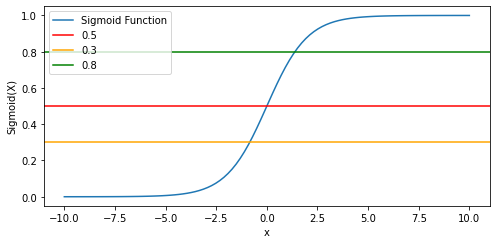

Relative Frequence of 1 0.43842364532019706
Relative Frequence of 0 0.5615763546798029


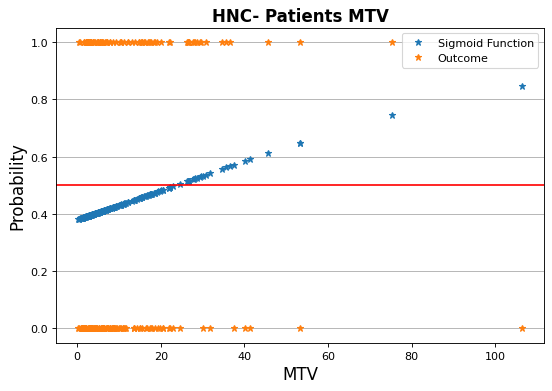

None
Relative Frequence of 1 0.43842364532019706
Relative Frequence of 0 0.5615763546798029


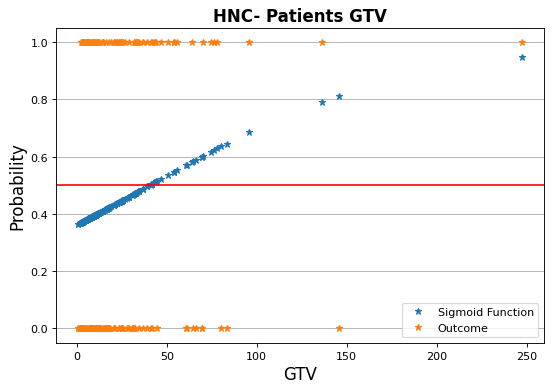

None
Relative Frequence of 1 0.43842364532019706
Relative Frequence of 0 0.5615763546798029


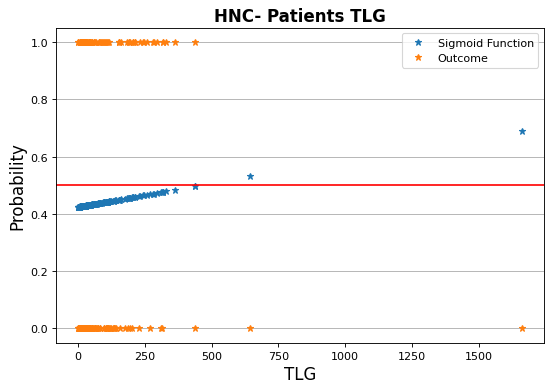

None
Relative Frequence of 1 0.43842364532019706
Relative Frequence of 0 0.5615763546798029


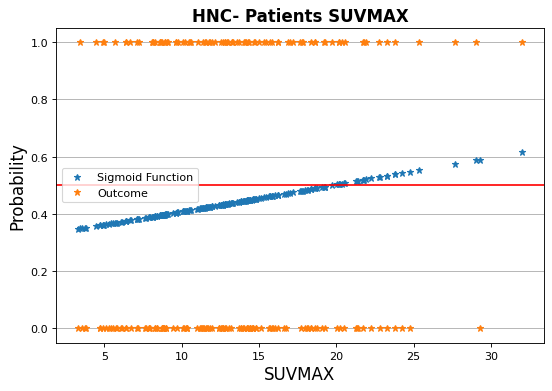

None
Relative Frequence of 1 0.43842364532019706
Relative Frequence of 0 0.5615763546798029


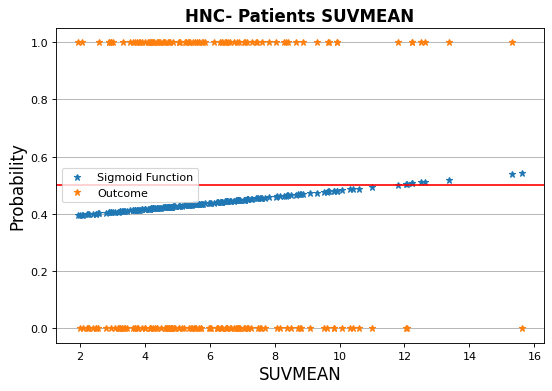

None
Relative Frequence of 1 0.43842364532019706
Relative Frequence of 0 0.5615763546798029


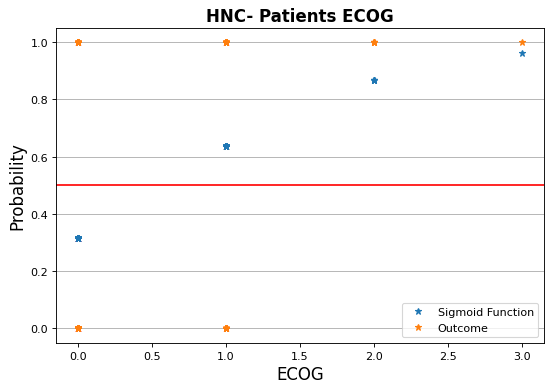

None


In [28]:
# Sigmoid function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% ! important; }<style>"))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

import matplotlib.pyplot as plt
import numpy as np
import math
  
x = np.linspace(-10, 10, 100)
z = 1/(1 + np.exp(-x))
  
plt.plot(x, z,label='Sigmoid Function')
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
plt.axhline(y = 0.5, color='r',linestyle='-',label='0.5')
plt.axhline(y = 0.3, color='orange',linestyle='-',label='0.3')
plt.axhline(y = 0.8, color='green',linestyle='-',label='0.8')
plt.legend()



plt.show()



# Below function does 2 things.
# Plots predictor versus Outcome
# Plots sigmoid function of the logistic regression method.
def SigmoidData(PatientGroup,Outcome,Predictor,k):
    y, X = AllData(Outcome,Predictor,k)
    a,b=(y.shape)
    Zeros=[]
    Ones =[]
    for i,j  in enumerate (y):
        if j == 0:
            Zeros.append(0)
        else:
            Ones.append(j)
    print('Relative Frequence of 1',len(Ones)/a)
    print('Relative Frequence of 0',len(Zeros)/a)
    clf = LogisticRegression().fit(X, y)
    # Creating sample Z points
    z = np.dot(X,clf.coef_)+clf.intercept_
    # Invoking Sigmoid function on all Z points
    plt.figure(figsize=(7, 5), dpi=80)
    phi_z = sigmoid(z)
    # Plotting the Sigmoid function
    plt.plot(X, phi_z,'*',label='Sigmoid Function',)
    plt.plot(X,y,'*',label='Outcome')
    #plt.axvline(0.0, color='k')
    plt.axhline(y = 0.5, color='r',linestyle='-')
    plt.xlabel(Predictor,fontsize=15)
    plt.ylabel('Probability',fontsize =15)
    plt.title(PatientGroup+ (Predictor),fontsize=15,fontweight='bold')
    #plt.yticks([0.0, 0.5, 1.0])
    ax = plt.gca()
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()
    




'''print(SigmoidData('HPV POSITIVE PATIENTS ','POS','ECOG',2))
print(SigmoidData('HPV POSITIVE PATIENTS ','POS','SUVMAX',2))
print(SigmoidData('HPV POSITIVE PATIENTS ','POS','SUVMEAN',2))
print(SigmoidData('HPV POSITIVE PATIENTS ','POS','TLG',7))
print(SigmoidData('HPV POSITIVE PATIENTS ','POS','MTV',2))
print(SigmoidData('HPV POSITIVE PATIENTS ','POS','GTV',2))
print(SigmoidData('HPV NEGATIVE PATIENTS ','NEG','SUVMAX',2))
print(SigmoidData('HPV NEGATIVE PATIENTS ','NEG','SUVMEAN',2))
print(SigmoidData('HPV NEGATIVE PATIENTS ','NEG','GTV',2))
print(SigmoidData('HPV NEGATIVE PATIENTS ','NEG','MTV',2))
print(SigmoidData('HPV NEGATIVE PATIENTS ','NEG','TLG',2))
print(SigmoidData('HPV NEGATIVE PATIENTS ','NEG','ECOG',2))'''
print(SigmoidData('HNC- Patients ','All','MTV',2))
print(SigmoidData('HNC- Patients ','All','GTV',2))
print(SigmoidData('HNC- Patients ','All','TLG',2))
print(SigmoidData('HNC- Patients ','All','SUVMAX',2))
print(SigmoidData('HNC- Patients ','All','SUVMEAN',2))
print(SigmoidData('HNC- Patients ','All','ECOG',2))


# Violin plots and histogram
- Violin plots and histogram plots are created here. 

None


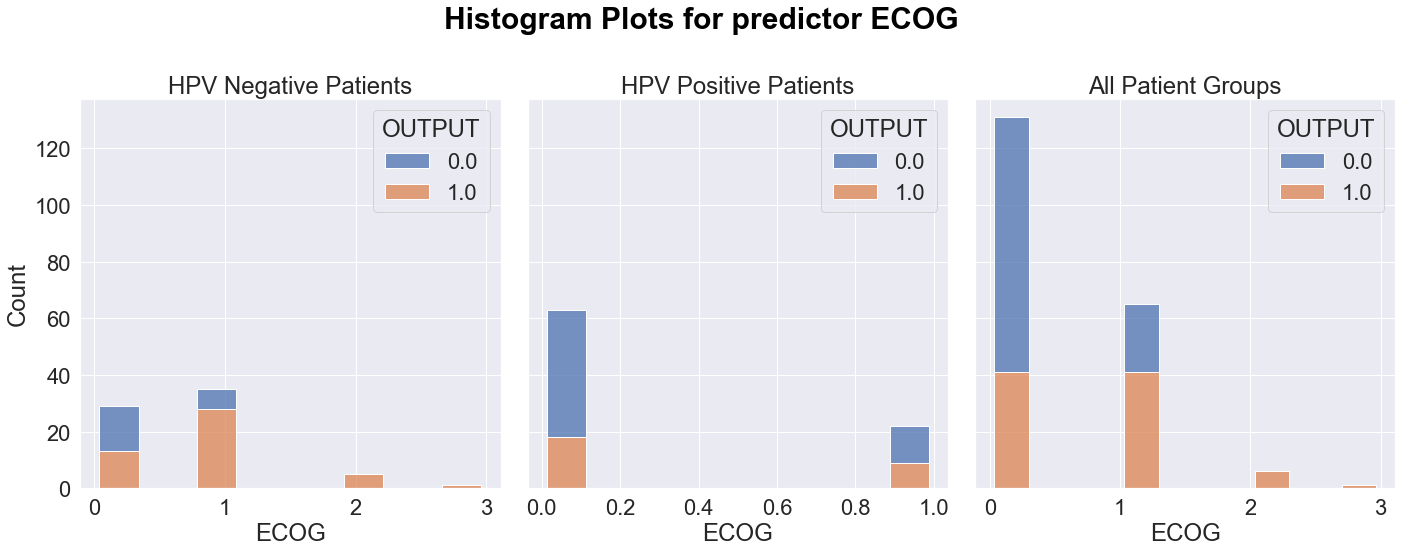

In [30]:
# Function that creates Pandas DataFrame.
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
def Pandas(TypeOfOutcome):
    Y,x_SUVMAX = AllData(TypeOfOutcome,'SUVMAX',1)
    Y,x_SUVMEAN = AllData(TypeOfOutcome,'SUVMEAN',1)
    Y,x_MTV = AllData(TypeOfOutcome,'MTV',1)
    Y,x_GTV = AllData(TypeOfOutcome,'GTV',1)
    Y,x_TLG = AllData(TypeOfOutcome,'TLG',1)
    Y,x_ECOG = AllData(TypeOfOutcome,'ECOG',1)
    sns.set(font_scale=2)
    # Create DataFrame
    df_HistVio = pd.DataFrame(columns=['SUVMEAN','SUVMAX','MTV','GTV','TLG','ECOG','OUTPUT'])
    df_Corr = pd.DataFrame(columns=['SUVMEAN','SUVMAX','MTV','GTV','TLG'])
    # Iterate to add Predictors and outcome to DataFrame
    for j,i in enumerate (x_SUVMEAN):
        df_HistVio = df_HistVio.append({'SUVMEAN': i[0],'SUVMAX': x_SUVMAX[j][0],'MTV': x_MTV[j][0],'GTV': x_GTV[j][0],'TLG': x_TLG[j][0],'ECOG': x_ECOG[j][0],'OUTPUT':Y[j][0]}, ignore_index=True)
        df_Corr = df_Corr.append({'SUVMEAN': i[0],'SUVMAX': x_SUVMAX[j][0],'MTV': x_MTV[j][0],'GTV': x_GTV[j][0],'TLG': x_TLG[j][0]}, ignore_index=True)
    return df_HistVio,df_Corr
PandasHPVNEG,PandasHPVNEG_Corr = Pandas('NEG')
PandasHPVPOS,PandasHPVPOS_Corr = Pandas('POS')
PandasAll,PandasAll_Corr = Pandas('All')





def HistoPredictor(Predictor):
    figure, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
    Text = 'Histogram Plots for predictor '
    Part = Predictor
    figure.suptitle(Text+ Part,fontsize=30,fontweight='bold',color='black')
    sns.histplot(ax = axes[0],data=PandasHPVNEG, x=Predictor,hue='OUTPUT', multiple="stack",shrink=.8, kde=False).set(title='HPV Negative Patients')
    sns.histplot(ax = axes[1],data=PandasHPVPOS, x=Predictor,hue='OUTPUT', multiple="stack",shrink=.8, kde=False).set(title='HPV Positive Patients')
    sns.histplot(ax = axes[2],data=PandasAll, x=Predictor,hue='OUTPUT', multiple="stack",shrink=.8, kde=False).set(title='All Patient Groups')

   
'''print(HistoPredictor('SUVMEAN'))
print(HistoPredictor('SUVMAX'))
print(HistoPredictor('MTV'))
print(HistoPredictor('GTV'))
print(HistoPredictor('TLG'))'''
print(HistoPredictor('ECOG'))
# Confusion sns matrix.

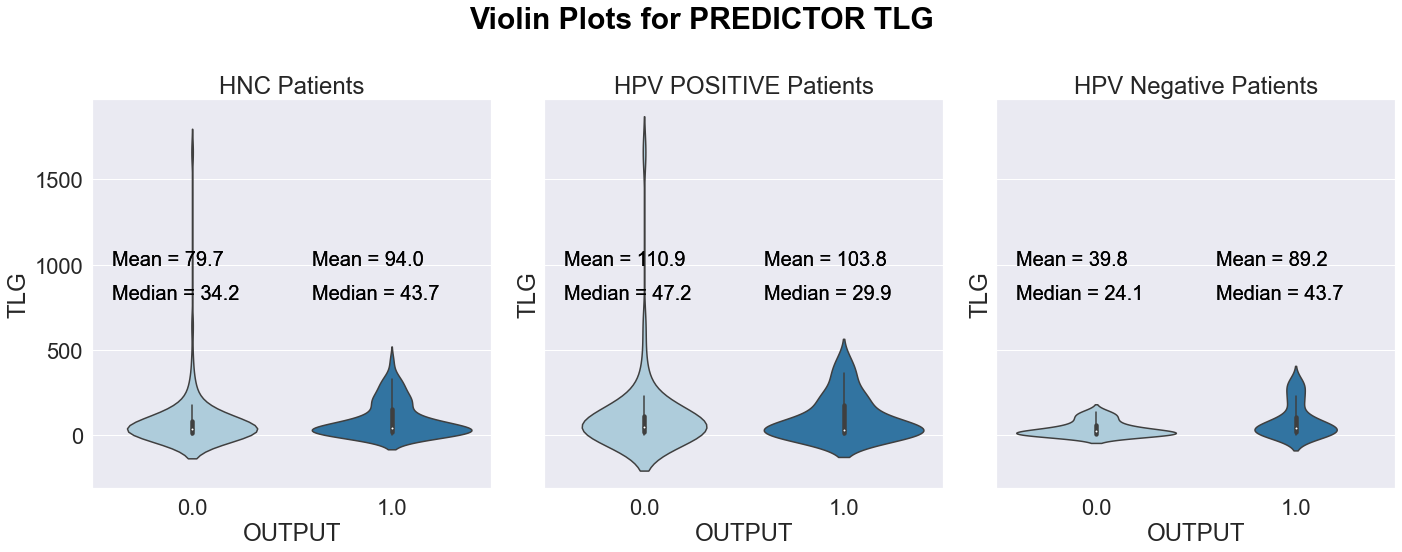

In [31]:
# Calculate mean and median for seaborn plot
# Calculating value for 'n':
def Mean_Median(Pandas,Predictor):
    Mean_List = Pandas.groupby(['OUTPUT'])[Predictor].mean().tolist()
    Median_List = Pandas.groupby(['OUTPUT'])[Predictor].median().tolist()
    return Mean_List,Median_List
#print(Mean_Median(PandasHPVNEG,'MTV'))
#ax = sns.violinplot(x="OUTPUT", y='GTV', data=PandasHPVNEG, palette="Paired")
'''ax_POS = sns.violinplot(ax = axes[1],x="OUTPUT", y='GTV', data=PandasHPVPOS, palette="Paired")
'''
# Violin plots for verious outcomes. Mean and Median of each plot is included as well.
def ViolinPlots(Predictor,Num,Numbi):
    figure, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
    Text = 'Violin Plots for PREDICTOR '
    Part = Predictor
    figure.suptitle(Text+ Part,fontsize=30,fontweight='bold',color='black')
    # Assigning a variable to our Violin plot:
    ax_NEG = sns.violinplot(ax = axes[2],x="OUTPUT", y=Predictor, data=PandasHPVNEG, palette="Paired")
    ax_POS = sns.violinplot(ax = axes[1],x="OUTPUT", y=Predictor, data=PandasHPVPOS, palette="Paired")
    ax_ALL = sns.violinplot(ax = axes[0],x="OUTPUT", y=Predictor, data=PandasAll, palette="Paired")



    #print(ax)
    Mean_NEG,Median_Neg =(Mean_Median(PandasHPVNEG,Predictor))
    Mean_POS,Median_POS =(Mean_Median(PandasHPVPOS,Predictor)) 
    Mean_ALL,Median_ALL =(Mean_Median(PandasAll,Predictor)) 
    ylist = (Mean_ALL)

    # Adding calculated value as Text to plot:
    for i in range(len(ylist)):
        ax_NEG.text(-0.4, Num, ('Mean = '+str(round(Mean_NEG[0],1))),size=20,color='black')
        ax_NEG.text(0.6, Num, ('Mean = '+str(round(Mean_NEG[1],1))),size=20,color='black')
        ax_NEG.text(-0.4, Numbi, ('Median = '+str(round(Median_Neg[0],1))),size=20,color='black')
        ax_NEG.text(0.6, Numbi, ('Median = '+str(round(Median_Neg[1],1))),size=20,color='black')
        ax_NEG.set(title='HPV Negative Patients')
        ax_POS.text(-0.4, Num, ('Mean = '+str(round(Mean_POS[0],1))),size=20,color='black')
        ax_POS.text(0.6, Num, ('Mean = '+str(round(Mean_POS[1],1))),size=20,color='black')
        ax_POS.text(-0.4, Numbi, ('Median = '+str(round(Median_POS[0],1))),size=20,color='black')
        ax_POS.text(0.6, Numbi, ('Median = '+str(round(Median_POS[1],1))),size=20,color='black')
        ax_POS.set(title='HPV POSITIVE Patients')
        ax_ALL.text(-0.4, Num, ('Mean = '+str(round(Mean_ALL[0],1))),size=20,color='black')
        ax_ALL.text(0.6, Num, ('Mean = '+str(round(Mean_ALL[1],1))),size=20,color='black')
        ax_ALL.text(-0.4, Numbi, ('Median = '+str(round(Median_ALL[0],1))),size=20,color='black')
        ax_ALL.text(0.6, Numbi, ('Median = '+str(round(Median_ALL[1],1))),size=20,color='black')
        ax_ALL.set(title='HNC Patients')

    plt.show()

ViolinPlots('TLG',1000,800)


# ROC CURVES
The ROC curves are plotted for three patient groups. This is to get a view, and a visualization of how things look.
- Monte Carlo Stratified Cross validation calculates different metrics such as AUC, F1-score, balanced accuracy, recall and accuracy.
- For every predictor, an optimal threshold is calculated with LOOCV. This is inserted in the function at "threshold".
- ROC-curve is also plotted using MCSCV. 

AUC for whole dataset 0.586240883106643
Mean f1 0.47512132750299213 Standard Deviation 0.0841578006659785
F1 97,5% 0.609176340519624 F1 2.5% 0.3355263157894737
Mean accuracy 0.5755391962725683 Standard Deviation 0.045638885110476514
Accuracy 97,5% 0.6534653465346535 Accuracy 2.5% 0.49006988934187545
Mean Balanced Accuracy 0.5883871004275663 Standard Deviation 0.07811931620152936
BalancedAccuracy 97,5% 0.775 Balanced Accuracy 2.5% 0.44217687074829926
Mean Recall_1 0.5309017485438484 Standard Deviation 0.23932989230106594
Recall_1 97,5% 1.0 Recall_1 2.5% 0.0
Mean Recall_0 0.5843360516123909 Standard Deviation 0.06310979352115748
recall_0 97,5% 0.6956521739130435 recall_0  2.5% 0.49019607843137253
Mean AUC 0.5758799815829089 Standard Deviation 0.058368111957858175
AUC 97,5% 0.6569211924475082 AUC 2.5% 0.36104841909390095


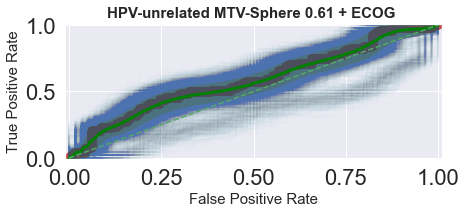

In [33]:
###### from sklearn import metrics
from sklearn.metrics import auc
#from scikitplot.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,average_precision_score
from sklearn.metrics import balanced_accuracy_score,brier_score_loss
import warnings
warnings.filterwarnings('ignore')

# This function is used for thresholding the calculated probabilities.
def y_score_Threshold(y_pred,i):
    a = []
    b = []
    for j in y_pred:
        if j <i:
            a.append(0)
        else:
            a.append(1)
    b.append(a)
    return b

# Funcion that produces extrapolated tprs with a base fpr. Also it plots a number of ROV-curves.
def ROC_tpr_fpr(Input,Predictor,size,k,threshold):
    Ydata,Xdata = AllData(Input,Predictor,k)
    X = np.array(Xdata) # Predictors stored here
    y = np.array(Ydata)# Outcome
    logreg = LogisticRegression().fit(X, y)
    y_score = logreg.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_score[:, 1])
    AUC = auc(fpr, tpr)
    print('AUC for whole dataset',AUC)
    plt.plot(fpr, tpr, 'r', alpha=1,linewidth=10)
    base_fpr = np.linspace(0, 1, 101) # I will extrapolate this later tpr. 
    idx = np.arange(0, len(y))
    # Will use this to later shuffle my data
    tprs = []
    aucs = []
    F1 = [] # F1-score calculated for each simulation is stored here. 
    BA = [] # Balanced accuracy calculated for each simulation is stored here
    A = [] # Accuracy calculated for each step is stored here
    recall_1=[] # Recall for DFS = 1 is stored here
    recall_0 = [] # Recall for DFS = 0 is stored here. 
    for j in np.random.randint(0, high=10000, size=size): # Velger tilfeldig j mellom 0 og 10 000. Velger ut 10 tall.
        np.random.shuffle(idx) # Jeg mixer tallene i idx
        cv = StratifiedKFold(n_splits=2,shuffle=True,random_state=j) # Cross validation. Split my data in 5
        for i, (train, test) in enumerate(cv.split(X,y)):
            logreg = LogisticRegression().fit(X[idx][train], y[idx][train])
            y_score = logreg.predict_proba(X[idx][test])
            y_pred = logreg.predict(X[idx][test])
            y_pred_thresh = y_score_Threshold(y_score[:, 1],threshold)
            balanced_accuracy = balanced_accuracy_score(y_pred_thresh[0], y[idx][test])
            accuracy = accuracy_score(y_pred_thresh[0], y[idx][test])
            f1 = f1_score(y_pred_thresh[0], y[idx][test],average='macro')
            recall = recall_score(y_pred_thresh[0], y[idx][test],average=None)
            recall_1.append(recall[1])
            recall_0.append(recall[0])
            F1.append(f1)
            BA.append(balanced_accuracy)
            A.append(accuracy)
            fpr, tpr, _ = roc_curve(y[idx][test], y_score[:, 1])
            AUC = auc(fpr, tpr)
            aucs.append(AUC)
            plt.plot(fpr, tpr, 'b', alpha=0.01)
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
    return tprs,base_fpr,aucs,F1,BA,A,recall_1,recall_0

# Insert Data information here. 
def ROC_PLOT_CURVE(Input,Predictor,size,k,threshold):
    tprs,base_fpr,aucs,F1,BA,A,recall_1,recall_0 = ROC_tpr_fpr(Input,Predictor,size,k,threshold)
    print('Mean f1',np.mean(F1),'Standard Deviation',np.std(F1))
    std_975_f1 = np.percentile(F1,97.5)
    std_25_f1 = np.percentile(F1,2.5)
    print('F1 97,5%',std_975_f1,'F1 2.5%',std_25_f1)
    print('Mean accuracy',np.mean(A),'Standard Deviation',np.std(A))
    std_975_a = np.percentile(A,97.5)
    std_25_a = np.percentile(A,2.5)
    print('Accuracy 97,5%',std_975_a,'Accuracy 2.5%',std_25_a)
    print('Mean Balanced Accuracy',np.mean(BA),'Standard Deviation',np.std(BA))
    std_975_ba = np.percentile(BA,97.5)
    std_25_ba = np.percentile(BA,2.5)
    print('BalancedAccuracy 97,5%',std_975_ba,'Balanced Accuracy 2.5%',std_25_ba)
    print('Mean Recall_1',np.mean(recall_1),'Standard Deviation',np.std(recall_1))
    std_975_r1 = np.percentile(recall_1,97.5)
    std_25_r1 = np.percentile(recall_1,2.5)
    print('Recall_1 97,5%',std_975_r1,'Recall_1 2.5%',std_25_r1)
    print('Mean Recall_0',np.mean(recall_0),'Standard Deviation',np.std(recall_0))
    std_975_r0 = np.percentile(recall_0,97.5)
    std_25_r0 = np.percentile(recall_0,2.5)
    print('recall_0 97,5%',std_975_r0,'recall_0  2.5%',std_25_r0)
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)
    print('Mean AUC',mean_auc,'Standard Deviation',std_auc)
    std_975 = np.percentile(aucs, 97.5)
    std_25 = np.percentile(aucs,2.5)
    print('AUC 97,5%',std_975,'AUC 2.5%',std_25)
    plt.plot(base_fpr, mean_tprs,alpha=1,linewidth=3,color='green')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=1)
    plt.plot([0, 1], [0, 1],'g--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.title('HPV-unrelated MTV-Sphere 0.61 + ECOG ',fontsize=15,fontweight='bold')
    #plt.rcParams['figure.figsize'] = [10/2.54, 8/2.54]
    plt.show()
    return np.mean(F1)
b = np.linspace(0.4,0.6,41)

A = (ROC_PLOT_CURVE('All','MTV',5000,4,0.5))